In [49]:
import pandas as pd
import numpy as np
import torch
import os
from tqdm import tqdm
import pickle
import gc
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Load the dataset
data_path = "/home/joaquino/portuguese-llm/data/merged_data_lemm.parquet"
df = pd.read_parquet(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (24000, 27)
Columns: ['messageId', 'message', 'trait', 'original_prompt', 'model', 'response', 'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density', 'token_quantity', 'adjective_list', 'substantive_list', 'genero', 'raca', 'regiao', 'localidade', 'unused', 'artigo', 'pronome', 'response_lemm']

First few rows:


,messageId,message,trait,original_prompt,model,response,responseId,udpipe_result,MLC,MLS,...,adjective_list,substantive_list,genero,raca,regiao,localidade,unused,artigo,pronome,response_lemm
0,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nascido e criado no Nor...",407b48b9-b0ed-5658-bba7-4180c43cd30c,"# generator = UDPipe 2, https://lindat.mff.cun...",20.272727,24.777778,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nascer e criar _ em o No...
1,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem preto, nascido e criado no Nor...",68156cbb-c93c-5d05-9ba6-cbb2e6d6ee55,"# generator = UDPipe 2, https://lindat.mff.cun...",22.000000,26.888889,...,"[{'id': 5, 'form': 'preto', 'lemma': 'preto', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem preto nascer e criar _ em o No...
2,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nordestino e carrego em...",da84a465-0723-5ccd-a449-65c89840bc1e,"# generator = UDPipe 2, https://lindat.mff.cun...",18.266667,27.400000,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nordestino e carregar em...
3,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, natural do Norte do Bra...",91f9690e-b62d-54dc-a365-9803475f3433,"# generator = UDPipe 2, https://lindat.mff.cun...",32.375000,21.583333,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro natural _ de o Norte _ d...
4,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nascido e criado no Nor...",aa059409-4765-5520-9caf-348a2c2911ee,"# generator = UDPipe 2, https://lindat.mff.cun...",15.722222,25.727273,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nascer e criar _ em o No...


In [51]:
# Improved helper function for loading embeddings as DataFrame with better organization
def load_embeddings_dataframe_with_responseId(embeddings_dir="/home/joaquino/portuguese-llm/embeddings/bert_embeddings", 
                                              responseId_first=True,
                                              as_tensor=False):
    """
    Load BERT embeddings as pandas DataFrame with responseId column
    
    Args:
        embeddings_dir (str): Directory containing the embeddings
        responseId_first (bool): If True, puts responseId as the first column for easier access
        as_tensor (bool): If True, returns embeddings as PyTorch tensors in a single column
    
    Returns:
        pd.DataFrame: DataFrame with responseId and embedding dimensions
                     - If as_tensor=True: columns are ['responseId', 'embedding'] where embedding is a torch.Tensor
                     - If responseId_first=True: columns are ['responseId', '0', '1', ..., 'n']
                     - If responseId_first=False: columns are ['0', '1', ..., 'n', 'responseId']
    """
    # Load the parquet file
    df_file = os.path.join(embeddings_dir, "bert_embeddings_df.parquet")
    
    if not os.path.exists(df_file):
        raise FileNotFoundError(f"Embedding DataFrame file not found: {df_file}")
    
    df = pd.read_parquet(df_file)
    
    if as_tensor:
        # Convert embedding columns to torch tensors
        embedding_cols = [col for col in df.columns if col != 'responseId']
        
        # Convert each row of embeddings to a torch tensor
        embeddings_as_tensors = []
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Converting to tensors"):
            # Get embedding values and ensure they're float32
            embedding_values = row[embedding_cols].values
            
            # Convert to float32 numpy array first to handle any type issues
            try:
                embedding_values = embedding_values.astype(np.float32)
            except (ValueError, TypeError) as e:
                print(f"Error converting row {idx} to float32: {e}")
                print(f"Row data types: {row[embedding_cols].dtypes}")
                print(f"Row values sample: {embedding_values[:5]}")
                raise
            
            # Now convert to torch tensor
            tensor_embedding = torch.from_numpy(embedding_values)
            embeddings_as_tensors.append(tensor_embedding)
        
        # Create new DataFrame with responseId and tensor embeddings
        result_df = pd.DataFrame({
            'responseId': df['responseId'].values,
            'embedding': embeddings_as_tensors
        })
        
        return result_df
    
    elif responseId_first:
        # Reorganize columns to put responseId first
        embedding_cols = [col for col in df.columns if col != 'responseId']
        df = df[['responseId'] + embedding_cols]
    
    return df

In [52]:
# Load embeddings as DataFrame with PyTorch tensors
df_with_responseId = load_embeddings_dataframe_with_responseId(as_tensor=True)

print(f"DataFrame shape: {df_with_responseId.shape}")
print(f"Columns: {list(df_with_responseId.columns)}")
print(f"First embedding tensor shape: {df_with_responseId['embedding'].iloc[0].shape}")
print(f"First embedding tensor type: {type(df_with_responseId['embedding'].iloc[0])}")

# Show first few rows
print("\nFirst few rows:")
df_with_responseId.head(3)

Converting to tensors:   0%|          | 0/24000 [00:00<?, ?it/s]

Converting to tensors: 100%|██████████| 24000/24000 [00:27<00:00, 863.76it/s] 



DataFrame shape: (24000, 2)
Columns: ['responseId', 'embedding']
First embedding tensor shape: torch.Size([1024])
First embedding tensor type: <class 'torch.Tensor'>

First few rows:


,responseId,embedding
0,407b48b9-b0ed-5658-bba7-4180c43cd30c,"[tensor(0.2816), tensor(0.1334), tensor(0.0859..."
1,68156cbb-c93c-5d05-9ba6-cbb2e6d6ee55,"[tensor(-0.3456), tensor(0.0247), tensor(0.021..."
2,da84a465-0723-5ccd-a449-65c89840bc1e,"[tensor(0.3745), tensor(0.2789), tensor(0.3072..."


## Vector Distance Analysis for Specific Model and Prompt

This section analyzes vector distances and similarities for embeddings from a specific model and prompt combination. The analysis includes:

1. **Data Filtering**: Filter data to specific model and prompt
2. **Cosine Similarity**: Calculate cosine similarities between mean embeddings 
3. **Centering Analysis**: Center embeddings by demographic means and recalculate similarities
4. **Pair Analysis**: Find most similar, dissimilar, and orthogonal embedding pairs
5. **Configuration Matching**: Analyze how demographic configuration affects similarity

In [53]:
def create_prompt_folder_name(original_prompt):
    """
    Create a meaningful folder name from the original prompt
    """
    # Remove XML tags and user wrapper
    clean_prompt = original_prompt.replace('<user>', '').replace('</user>', '').strip()
    
    # Map common prompt patterns to descriptive names
    prompt_mappings = {
        'Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva na primeira pessoa.': 'imagine_yourself_first_person',
        'Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}} na primeira pessoa.': 'describe_first_person',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. A descreva sem dizer que ela é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}.': 'imagine_someone_without_saying',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, descreva-a.': 'imagine_someone_please_describe',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.': 'imagine_someone_describe',
        'Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}.': 'describe_simple',
        'Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva.': 'imagine_yourself',
        'Imagine uma pessoa {{raca}} {{genero}} {{regiao}} {{localidade}}. Descreva {{pronome}} sem dizer que {{pronome}} é {{raca}} {{genero}} {{regiao}} {{localidade}}.': 'imagine_someone_indirect_third_person'
    }
    
    # Check if we have a mapping for this exact prompt
    if clean_prompt in prompt_mappings:
        return prompt_mappings[clean_prompt]
    
    # If no exact mapping, create a safe name from the content
    # Take key words and create a descriptive name
    if 'você é uma pessoa' in clean_prompt and 'primeira pessoa' in clean_prompt:
        return 'imagine_yourself_first_person'
    elif 'você é uma pessoa' in clean_prompt and 'Se descreva' in clean_prompt:
        return 'imagine_yourself'
    elif 'Descreva uma pessoa' in clean_prompt and 'primeira pessoa' in clean_prompt:
        return 'describe_first_person'
    elif 'Imagine uma pessoa' in clean_prompt and 'sem dizer' in clean_prompt:
        return 'imagine_someone_without_saying'
    elif 'Imagine uma pessoa' in clean_prompt and 'Por favor' in clean_prompt:
        return 'imagine_someone_please_describe'
    elif 'Imagine uma pessoa' in clean_prompt and 'Descreva-a' in clean_prompt:
        return 'imagine_someone_describe'
    elif 'Descreva uma pessoa' in clean_prompt:
        return 'describe_simple'
    elif '{{pronome}}' in clean_prompt:
        return 'imagine_someone_indirect_third_person'
    else:
        # Fallback: create a safe name from the first few words
        words = clean_prompt.split()[:3]
        safe_name = '_'.join(word.lower().replace('.', '').replace(',', '').replace('?', '').replace('!', '') 
                           for word in words if word.replace('{', '').replace('}', '').isalpha())
        return safe_name if safe_name else 'unknown_prompt'

In [54]:
# Join the original dataset with the embeddings DataFrame (now with tensors)
print("Joining datasets...")
print(f"Original dataset shape: {df.shape}")
print(f"Embeddings dataset shape: {df_with_responseId.shape}")

# Join on responseId column
merged_df = df.merge(df_with_responseId, on='responseId', how='inner')
merged_df["safe_prompt_name"] = merged_df['original_prompt'].apply(create_prompt_folder_name)


print(f"Merged dataset shape: {merged_df.shape}")
print(f"Columns in merged dataset: {len(merged_df.columns)}")

# Show some info about the join
print(f"\nJoin statistics:")
print(f"- Original dataset: {len(df)} rows")
print(f"- Embeddings dataset: {len(df_with_responseId)} rows")
print(f"- Merged dataset: {len(merged_df)} rows")
print(f"- Rows matched: {len(merged_df)} / {len(df)} ({len(merged_df)/len(df)*100:.1f}%)")

# Show the structure
print(f"\nMerged dataset columns:")
original_cols = [col for col in merged_df.columns if col != 'embedding']
print(f"- Original columns: {len(original_cols)}")
print(f"- Embedding column: 1 (contains torch tensors)")
print(f"- Sample embedding shape: {merged_df['embedding'].iloc[0].shape}")

print(f"\nFirst few columns (excluding embedding): {list(merged_df.columns[:10])}")

Joining datasets...
Original dataset shape: (24000, 27)
Embeddings dataset shape: (24000, 2)
Merged dataset shape: (24000, 29)
Columns in merged dataset: 29

Join statistics:
- Original dataset: 24000 rows
- Embeddings dataset: 24000 rows
- Merged dataset: 24000 rows
- Rows matched: 24000 / 24000 (100.0%)

Merged dataset columns:
- Original columns: 28
- Embedding column: 1 (contains torch tensors)
- Sample embedding shape: torch.Size([1024])

First few columns (excluding embedding): ['messageId', 'message', 'trait', 'original_prompt', 'model', 'response', 'responseId', 'udpipe_result', 'MLC', 'MLS']


In [55]:
config_cols = ['genero', 'raca', 'regiao', 'safe_prompt_name']
config_cols_to_print = config_cols + ["model"]

In [56]:
filtered_df = merged_df

In [57]:
# Calculate mean embeddings grouped by messageId
def calculate_mean_embedding(group):
    embeddings_list = group['embedding'].tolist()
    stacked_embeddings = torch.stack(embeddings_list)
    mean_embedding = torch.mean(stacked_embeddings, dim=0)
    
    # Get config values (same for all responses in group)
    config_values = group[config_cols_to_print].iloc[0]
    
    result = {'mean_embedding': mean_embedding}
    result.update(config_values.to_dict())
    
    return pd.Series(result)

# Group by messageId and calculate mean embeddings with config
grouped = filtered_df.groupby('messageId').apply(calculate_mean_embedding)

mean_embeddings_df = grouped.reset_index()

print(f"Mean embeddings with config: {mean_embeddings_df.shape}")
print(f"Columns: {list(mean_embeddings_df.columns)}")
mean_embeddings_df.head()

Mean embeddings with config: (2400, 7)
Columns: ['messageId', 'mean_embedding', 'genero', 'raca', 'regiao', 'safe_prompt_name', 'model']


,messageId,mean_embedding,genero,raca,regiao,safe_prompt_name,model
0,001d90e7-d0db-567e-83b3-e5da536359e9,"[tensor(-0.0427), tensor(0.2261), tensor(0.509...",homem,preta,sulista,imagine_yourself,gemini-2.0-flash
1,001fbe3b-d84b-5428-9d90-4ce0bd12c055,"[tensor(0.0581), tensor(0.3452), tensor(-0.321...",não-binária,amarela,sulista,imagine_someone_indirect_third_person,gemini-2.0-flash
2,005bd095-a332-54d5-93fb-8e10d84e7aa1,"[tensor(0.4885), tensor(0.0735), tensor(0.1691...",mulher,preta,nortista,imagine_someone_describe,gemini-2.0-flash
3,006444d8-fc21-5caf-9154-3d08827d1902,"[tensor(-0.3232), tensor(0.4686), tensor(-0.31...",não-binária,preta,centro-oestina,imagine_someone_indirect_third_person,gemini-2.0-flash
4,008662a4-215d-54fc-a024-603eaa2380b3,"[tensor(-0.1262), tensor(0.5302), tensor(0.131...",homem,amarela,nordestina,describe_simple,gemini-1.5-flash


In [58]:
def calculate_config_match_percentage(row1, row2, config_columns):
    """
    Calculate the percentage of configuration values that match between two rows.
    
    Args:
        row1, row2: DataFrame rows to compare
        config_columns: List of column names to compare
        
    Returns:
        float: Percentage of matching config values (0-100)
    """
    matches = 0
    to_compare = config_cols_to_print
    total = len(to_compare)

    for col in to_compare:
        if row1[col] == row2[col]:
            matches += 1
    
    return (matches / total) * 100 if total > 0 else 0

In [59]:
# Get original embeddings (without centering)
original_embeddings = []
for idx, row in mean_embeddings_df.iterrows():
    original_embeddings.append(row['mean_embedding'])

original_tensor = torch.stack(original_embeddings)

# Normalize the original embeddings
normalized_original_embeddings = torch.nn.functional.normalize(original_tensor, p=2, dim=1)

# Compute cosine similarity matrix
original_similarity_matrix = torch.mm(normalized_original_embeddings, normalized_original_embeddings.t())

# Set diagonal to -2 to exclude self-similarities
original_similarity_matrix.fill_diagonal_(-2)

tensor([[-2.0000,  0.7156,  0.6809,  ...,  0.8110,  0.7541,  0.7679],
        [ 0.7156, -2.0000,  0.7317,  ...,  0.7222,  0.8387,  0.8110],
        [ 0.6809,  0.7317, -2.0000,  ...,  0.7261,  0.8366,  0.7161],
        ...,
        [ 0.8110,  0.7222,  0.7261,  ..., -2.0000,  0.8468,  0.6315],
        [ 0.7541,  0.8387,  0.8366,  ...,  0.8468, -2.0000,  0.7378],
        [ 0.7679,  0.8110,  0.7161,  ...,  0.6315,  0.7378, -2.0000]])

In [60]:
# Get upper triangular part to avoid duplicate pairs
original_upper_mask = torch.triu(torch.ones_like(original_similarity_matrix, dtype=torch.bool), diagonal=1)
original_similarity_values = original_similarity_matrix[original_upper_mask]


# Find most similar, dissimilar, and orthogonal pairs (without centering)
original_indices = torch.nonzero(original_upper_mask, as_tuple=False)
original_sorted_indices = torch.argsort(original_similarity_values, descending=True)

print("\nTop 10 MOST SIMILAR pairs (WITHOUT centering):")
for k in range(10):
    idx = original_sorted_indices[k]
    i, j = original_indices[idx][0].item(), original_indices[idx][1].item()
    sim = original_similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    
    print(f"{k+1:2d}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

print("Top 10 MOST DISSIMILAR pairs (WITHOUT centering):")
for k in range(10):
    idx = original_sorted_indices[-(k+1)]
    i, j = original_indices[idx][0].item(), original_indices[idx][1].item()
    sim = original_similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    
    print(f"{k+1:2d}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

# Find pairs closest to 0 (orthogonal) without centering
abs_original_similarity_values = torch.abs(original_similarity_values)
original_orthogonal_sorted_indices = torch.argsort(abs_original_similarity_values)

print("Top 10 MOST ORTHOGONAL pairs (WITHOUT centering, closest to 0):")
for k in range(10):
    idx = original_orthogonal_sorted_indices[k]
    i, j = original_indices[idx][0].item(), original_indices[idx][1].item()
    sim = original_similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    
    print(f"{k+1:2d}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()


Top 10 MOST SIMILAR pairs (WITHOUT centering):
 1. Sim: 0.9947, Config Match: 80.0%
   Row i: {'genero': 'homem', 'raca': 'indígena', 'regiao': 'centro-oestina', 'safe_prompt_name': 'imagine_someone_please_describe', 'model': 'gemini-2.0-flash'}
   Row j: {'genero': 'homem', 'raca': 'indígena', 'regiao': 'centro-oestina', 'safe_prompt_name': 'imagine_someone_describe', 'model': 'gemini-2.0-flash'}

 2. Sim: 0.9940, Config Match: 80.0%
   Row i: {'genero': 'mulher', 'raca': 'parda', 'regiao': 'nortista', 'safe_prompt_name': 'imagine_someone_describe', 'model': 'gemini-2.0-flash'}
   Row j: {'genero': 'mulher', 'raca': 'parda', 'regiao': 'nortista', 'safe_prompt_name': 'imagine_someone_please_describe', 'model': 'gemini-2.0-flash'}

 3. Sim: 0.9938, Config Match: 80.0%
   Row i: {'genero': 'mulher', 'raca': 'preta', 'regiao': 'nordestina', 'safe_prompt_name': 'imagine_yourself_first_person', 'model': 'gpt-4o'}
   Row j: {'genero': 'mulher', 'raca': 'preta', 'regiao': 'nordestina', 'safe

In [61]:
# Identify unique combinations of model and original_prompt
unique_combinations = filtered_df[['model', 'original_prompt']].drop_duplicates()
print(f"Found {len(unique_combinations)} unique model+prompt combinations")

Found 32 unique model+prompt combinations


In [62]:
# Calculate config means for each model+prompt combination
config_means_by_combination = {}

for combo_idx, combo_row in unique_combinations.iterrows():
    current_model = combo_row['model']
    current_prompt = combo_row['original_prompt']
    combo_key = f"{current_model}_{current_prompt}"
    
    # Filter data to this specific model+prompt combination
    combo_data = filtered_df[
        (filtered_df['model'] == current_model) & 
        (filtered_df['original_prompt'] == current_prompt)
    ]
        
    # Group by messageId and calculate mean embeddings
    combo_grouped = combo_data.groupby('messageId').apply(
        lambda group: pd.Series({
            'mean_embedding': torch.mean(torch.stack(group['embedding'].tolist()), dim=0),
            **{col: group[col].iloc[0] for col in config_cols}
        })
    ).reset_index()
    
    # Calculate config means for each config column
    combo_config_means = {}
    for col in config_cols:
        col_means = {}
        for value in combo_grouped[col].unique():
            subset = combo_grouped[combo_grouped[col] == value]
            embeddings_list = subset['mean_embedding'].tolist()
            stacked_embeddings = torch.stack(embeddings_list)
            col_means[value] = torch.mean(stacked_embeddings, dim=0)
        combo_config_means[col] = col_means
    
    # Store results
    config_means_by_combination[combo_key] = {
        'model': current_model,
        'original_prompt': current_prompt,
        'config_means': combo_config_means,
        'total_messages': len(combo_grouped),
        'total_responses': len(combo_data)
    }

print(f"Calculated config means for {len(config_means_by_combination)} combinations")

Calculated config means for 32 combinations


In [63]:
# Create mapping from messageId to model+prompt combination
messageId_to_combo = {}
for idx, row in filtered_df.iterrows():
    messageId = row['messageId']
    combo_key = f"{row['model']}_{row['original_prompt']}"
    messageId_to_combo[messageId] = combo_key

In [64]:
# Create centered embeddings using combination-specific 'mulher' embeddings
centered_embeddings = []

for idx, row_data in mean_embeddings_df.iterrows():
    current_embedding = row_data['mean_embedding']
    current_messageId = row_data['messageId']
    
    # Get the appropriate combination for this messageId
    combo_key = messageId_to_combo[current_messageId]
    combo_config_means = config_means_by_combination[combo_key]['config_means']
    
    # Center by subtracting the 'mulher' embedding for this combination
    mulher_embedding = combo_config_means['genero']['mulher']
    centered = current_embedding - mulher_embedding
    centered_embeddings.append(centered)

# Stack into tensor
centered_tensor = torch.stack(centered_embeddings)
print(f"Created {len(centered_embeddings)} centered embeddings")

Created 2400 centered embeddings


In [65]:
# Normalize the centered embeddings
normalized_embeddings = torch.nn.functional.normalize(centered_tensor, p=2, dim=1)

# Compute cosine similarity matrix (dot product of normalized vectors)
similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.t())

# Set diagonal to -2 to exclude self-similarities
similarity_matrix.fill_diagonal_(-2)

# Get upper triangular part to avoid duplicate pairs
upper_triangular_mask = torch.triu(torch.ones_like(similarity_matrix, dtype=torch.bool), diagonal=1)
similarity_values = similarity_matrix[upper_triangular_mask]

print(f"Number of unique pairs: {len(similarity_values)}")
print(f"Similarity range: {similarity_values.min().item():.4f} to {similarity_values.max().item():.4f}")

Number of unique pairs: 2878800
Similarity range: -0.8032 to 0.9844


In [66]:
# Find most similar and dissimilar pairs
indices = torch.nonzero(upper_triangular_mask, as_tuple=False)
sorted_indices = torch.argsort(similarity_values, descending=True)

print("Top 10 MOST SIMILAR pairs (after centering by mulher):")
for k in range(10):
    idx = sorted_indices[k]
    i, j = indices[idx][0].item(), indices[idx][1].item()
    sim = similarity_values[idx].item()
    
    # Use .iloc with valid indices
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    
    # Get original similarity for comparison
    original_sim = original_similarity_values[idx].item()
    
    print(f"{k+1:2d}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

print("Top 10 MOST DISSIMILAR pairs (after centering by mulher):")
for k in range(10):
    idx = sorted_indices[-(k+1)]
    i, j = indices[idx][0].item(), indices[idx][1].item()
    sim = similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    original_sim = original_similarity_values[idx].item()
    
    print(f"{k+1:2d}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

print("Top 10 MOST ORTHOGONAL pairs (closest to 0, after centering by mulher):")
abs_similarity_values = torch.abs(similarity_values)
orthogonal_sorted_indices = torch.argsort(abs_similarity_values)

for k in range(10):
    idx = orthogonal_sorted_indices[k]
    i, j = indices[idx][0].item(), indices[idx][1].item()
    sim = similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    original_sim = original_similarity_values[idx].item()
    
    print(f"{k+1:2d}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

Top 10 MOST SIMILAR pairs (after centering by mulher):
 1. Centered: 0.9844, Original: 0.9916, Config Match: 80.0%
   Row i: {'genero': 'homem', 'raca': 'branca', 'regiao': 'nortista', 'safe_prompt_name': 'imagine_someone_describe', 'model': 'gpt-4o-mini'}
   Row j: {'genero': 'homem', 'raca': 'branca', 'regiao': 'nortista', 'safe_prompt_name': 'imagine_someone_please_describe', 'model': 'gpt-4o-mini'}

 2. Centered: 0.9834, Original: 0.9915, Config Match: 80.0%
   Row i: {'genero': 'homem', 'raca': 'parda', 'regiao': 'centro-oestina', 'safe_prompt_name': 'imagine_someone_describe', 'model': 'gpt-4o-mini'}
   Row j: {'genero': 'homem', 'raca': 'parda', 'regiao': 'centro-oestina', 'safe_prompt_name': 'imagine_someone_please_describe', 'model': 'gpt-4o-mini'}

 3. Centered: 0.9821, Original: 0.9918, Config Match: 80.0%
   Row i: {'genero': 'homem', 'raca': 'indígena', 'regiao': 'sulista', 'safe_prompt_name': 'imagine_someone_indirect_third_person', 'model': 'gpt-4o-mini'}
   Row j: {'gen

In [67]:
# Analysis filtered for genero = "mulher" only
mulher_only_df = mean_embeddings_df[mean_embeddings_df['genero'] == 'mulher'].copy()
print(f"Analyzing {len(mulher_only_df)} rows with genero='mulher'")

# Get original embeddings for mulher-only data
mulher_original_embeddings = [row['mean_embedding'] for idx, row in mulher_only_df.iterrows()]
mulher_original_tensor = torch.stack(mulher_original_embeddings)
mulher_normalized_original = torch.nn.functional.normalize(mulher_original_tensor, p=2, dim=1)

# Compute original similarity matrix for mulher-only data
mulher_original_similarity_matrix = torch.mm(mulher_normalized_original, mulher_normalized_original.t())
mulher_original_similarity_matrix.fill_diagonal_(-2)
mulher_original_upper_mask = torch.triu(torch.ones_like(mulher_original_similarity_matrix, dtype=torch.bool), diagonal=1)
mulher_original_similarity_values = mulher_original_similarity_matrix[mulher_original_upper_mask]

# Get first combination's mulher embedding for centering
first_combo_key = list(config_means_by_combination.keys())[0]
mulher_embedding = config_means_by_combination[first_combo_key]['config_means']['genero']['mulher']

# Create centered embeddings for mulher-only data
centered_mulher_embeddings = [row['mean_embedding'] - mulher_embedding for idx, row in mulher_only_df.iterrows()]
centered_mulher_tensor = torch.stack(centered_mulher_embeddings)
normalized_mulher_embeddings = torch.nn.functional.normalize(centered_mulher_tensor, p=2, dim=1)

# Compute centered similarity matrix for mulher-only data
mulher_similarity_matrix = torch.mm(normalized_mulher_embeddings, normalized_mulher_embeddings.t())
mulher_similarity_matrix.fill_diagonal_(-2)
upper_mask = torch.triu(torch.ones_like(mulher_similarity_matrix, dtype=torch.bool), diagonal=1)
mulher_similarity_values = mulher_similarity_matrix[upper_mask]

print(f"Similarity range: {mulher_similarity_values.min().item():.4f} to {mulher_similarity_values.max().item():.4f}")

# Find most similar, dissimilar and orthogonal pairs
mulher_indices = torch.nonzero(upper_mask, as_tuple=False)
mulher_sorted_indices = torch.argsort(mulher_similarity_values, descending=True)

print("\nTop 5 MOST SIMILAR pairs (mulher-only, after centering):")
for k in range(min(5, len(mulher_sorted_indices))):
    idx = mulher_sorted_indices[k]
    i, j = mulher_indices[idx][0].item(), mulher_indices[idx][1].item()
    sim = mulher_similarity_values[idx].item()
    original_sim = mulher_original_similarity_values[idx].item()
    
    row_i = mulher_only_df.iloc[i]
    row_j = mulher_only_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    print(f"{k+1}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols].to_dict()}")
    print(f"   Row j: {row_j[config_cols].to_dict()}")
    print()

print("Top 5 MOST DISSIMILAR pairs (mulher-only, after centering):")
for k in range(min(5, len(mulher_sorted_indices))):
    idx = mulher_sorted_indices[-(k+1)]
    i, j = mulher_indices[idx][0].item(), mulher_indices[idx][1].item()
    sim = mulher_similarity_values[idx].item()
    original_sim = mulher_original_similarity_values[idx].item()
    
    row_i = mulher_only_df.iloc[i]
    row_j = mulher_only_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    print(f"{k+1}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols].to_dict()}")
    print(f"   Row j: {row_j[config_cols].to_dict()}")
    print()

print("Top 5 MOST ORTHOGONAL pairs (mulher-only, closest to 0, after centering):")
abs_mulher_similarity_values = torch.abs(mulher_similarity_values)
mulher_orthogonal_sorted_indices = torch.argsort(abs_mulher_similarity_values)

for k in range(min(5, len(mulher_orthogonal_sorted_indices))):
    idx = mulher_orthogonal_sorted_indices[k]
    i, j = mulher_indices[idx][0].item(), mulher_indices[idx][1].item()
    sim = mulher_similarity_values[idx].item()
    original_sim = mulher_original_similarity_values[idx].item()
    
    row_i = mulher_only_df.iloc[i]
    row_j = mulher_only_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    print(f"{k+1}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols].to_dict()}")
    print(f"   Row j: {row_j[config_cols].to_dict()}")
    print()

Analyzing 800 rows with genero='mulher'
Similarity range: -0.6905 to 0.9899

Top 5 MOST SIMILAR pairs (mulher-only, after centering):
1. Centered: 0.9899, Original: 0.9940, Config Match: 80.0%
   Row i: {'genero': 'mulher', 'raca': 'parda', 'regiao': 'nortista', 'safe_prompt_name': 'imagine_someone_describe'}
   Row j: {'genero': 'mulher', 'raca': 'parda', 'regiao': 'nortista', 'safe_prompt_name': 'imagine_someone_please_describe'}

2. Centered: 0.9850, Original: 0.9926, Config Match: 80.0%
   Row i: {'genero': 'mulher', 'raca': 'indígena', 'regiao': 'nortista', 'safe_prompt_name': 'imagine_someone_please_describe'}
   Row j: {'genero': 'mulher', 'raca': 'indígena', 'regiao': 'nortista', 'safe_prompt_name': 'imagine_someone_describe'}

3. Centered: 0.9846, Original: 0.9905, Config Match: 80.0%
   Row i: {'genero': 'mulher', 'raca': 'branca', 'regiao': 'sulista', 'safe_prompt_name': 'imagine_someone_describe'}
   Row j: {'genero': 'mulher', 'raca': 'branca', 'regiao': 'sulista', 'safe_p

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
# Create similar plot for mulher-only data
mulher_plot_data = []
mulher_indices = torch.nonzero(upper_mask, as_tuple=False)

for idx_pos in range(len(mulher_similarity_values)):
    i, j = mulher_indices[idx_pos][0].item(), mulher_indices[idx_pos][1].item()
    sim = mulher_similarity_values[idx_pos].item()
    
    row_i = mulher_only_df.iloc[i]
    row_j = mulher_only_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    mulher_plot_data.append({
        'cosine_similarity': sim,
        'config_match': config_match
    })

mulher_plot_df = pd.DataFrame(mulher_plot_data)

In [70]:
comparison_data = []
# Ensure we're comparing the same pairs
for idx_pos in range(min(len(similarity_values), len(original_similarity_values))):
    # Get similarities for the same pair
    centered_sim = similarity_values[idx_pos].item()
    original_sim = original_similarity_values[idx_pos].item()
    
    # Get config match for this pair
    i, j = indices[idx_pos][0].item(), indices[idx_pos][1].item()
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    comparison_data.append({
        'centered_similarity': centered_sim,
        'original_similarity': original_sim,
        'config_match': config_match
    })

comparison_df = pd.DataFrame(comparison_data)                                              

In [71]:
# Calculate correlation between centered and original similarities
correlation = comparison_df['centered_similarity'].corr(comparison_df['original_similarity'])
print(f"Correlation between centered and original similarities: {correlation:.6f}")

Correlation between centered and original similarities: 0.336007


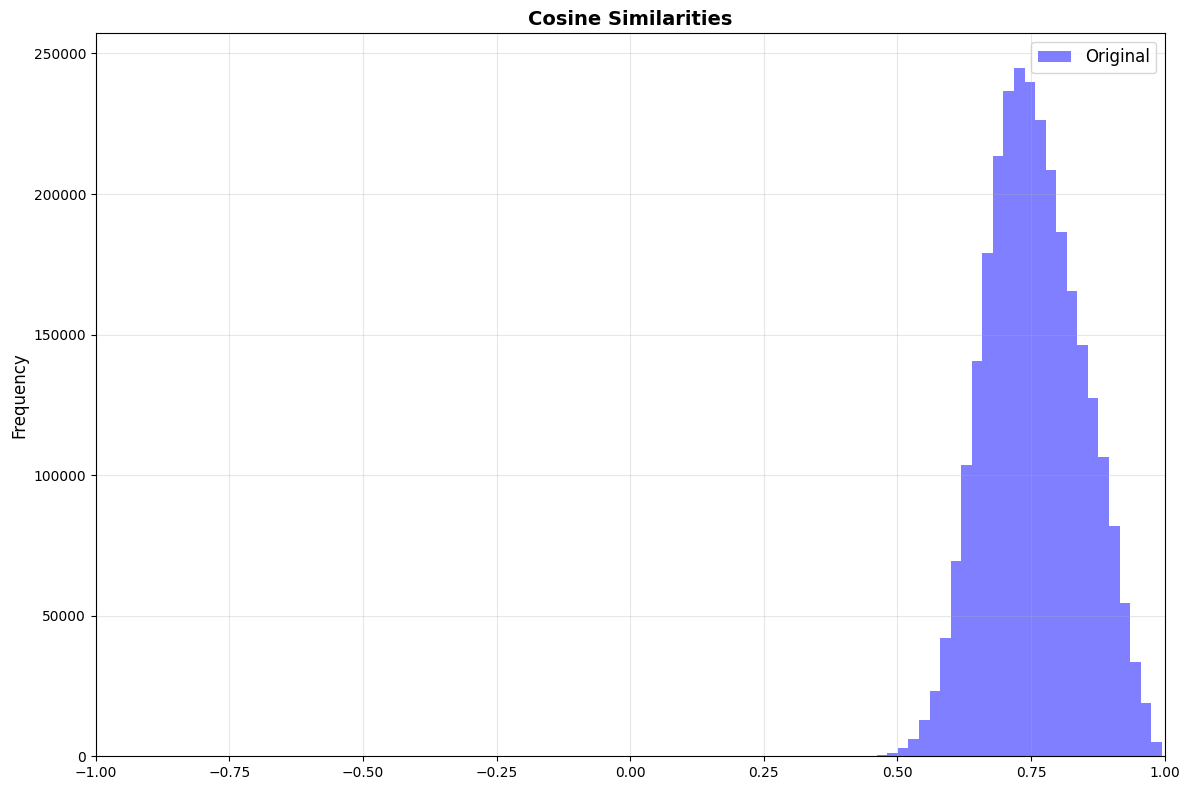

In [75]:
# Create histogram comparison plot
plt.figure(figsize=(12, 8))
plt.hist(comparison_df['original_similarity'], alpha=0.5, bins=30, label='Original', color='blue')
# plt.hist(comparison_df['centered_similarity'], alpha=0.5, bins=30, label='Centered (relative to "mulher")', color='red')
plt.title('Cosine Similarities', fontweight='bold', fontsize=14)
# plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(-1, 1)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
# os.makedirs('/home/joaquino/portuguese-llm/embeddings/plots', exist_ok=True)
# plt.savefig('/home/joaquino/portuguese-llm/embeddings/plots/similarity_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def create_prompt_folder_name(original_prompt):
    """
    Create a meaningful folder name from the original prompt
    """
    # Remove XML tags and user wrapper
    clean_prompt = original_prompt.replace('<user>', '').replace('</user>', '').strip()
    
    # Map common prompt patterns to descriptive names
    prompt_mappings = {
        'Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva na primeira pessoa.': 'imagine_yourself_first_person',
        'Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}} na primeira pessoa.': 'describe_first_person',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. A descreva sem dizer que ela é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}.': 'imagine_someone_without_saying',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, descreva-a.': 'imagine_someone_please_describe',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.': 'imagine_someone_describe',
        'Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}.': 'describe_simple',
        'Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva.': 'imagine_yourself',
        'Imagine uma pessoa {{raca}} {{genero}} {{regiao}} {{localidade}}. Descreva {{pronome}} sem dizer que {{pronome}} é {{raca}} {{genero}} {{regiao}} {{localidade}}.': 'imagine_someone_indirect_third_person'
    }
    
    # Check if we have a mapping for this exact prompt
    if clean_prompt in prompt_mappings:
        return prompt_mappings[clean_prompt]
    
    # If no exact mapping, create a safe name from the content
    # Take key words and create a descriptive name
    if 'você é uma pessoa' in clean_prompt and 'primeira pessoa' in clean_prompt:
        return 'imagine_yourself_first_person'
    elif 'você é uma pessoa' in clean_prompt and 'Se descreva' in clean_prompt:
        return 'imagine_yourself'
    elif 'Descreva uma pessoa' in clean_prompt and 'primeira pessoa' in clean_prompt:
        return 'describe_first_person'
    elif 'Imagine uma pessoa' in clean_prompt and 'sem dizer' in clean_prompt:
        return 'imagine_someone_without_saying'
    elif 'Imagine uma pessoa' in clean_prompt and 'Por favor' in clean_prompt:
        return 'imagine_someone_please_describe'
    elif 'Imagine uma pessoa' in clean_prompt and 'Descreva-a' in clean_prompt:
        return 'imagine_someone_describe'
    elif 'Descreva uma pessoa' in clean_prompt:
        return 'describe_simple'
    elif '{{pronome}}' in clean_prompt:
        return 'imagine_someone_indirect_third_person'
    else:
        # Fallback: create a safe name from the first few words
        words = clean_prompt.split()[:3]
        safe_name = '_'.join(word.lower().replace('.', '').replace(',', '').replace('?', '').replace('!', '') 
                           for word in words if word.replace('{', '').replace('}', '').isalpha())
        return safe_name if safe_name else 'unknown_prompt'


In [ ]:
import os
import json
from datetime import datetime

# Create organized directory structure for results
base_results_dir = f"/home/joaquino/portuguese-llm/embeddings/embedding_analysis_results"

# Create directories
os.makedirs(base_results_dir, exist_ok=True)

print(f"Results will be saved to: {base_results_dir}")

# Comprehensive analysis for all config_means by combination
def analyze_similarity_pairs(embeddings_df, center_embedding, config_cols, analysis_type="similarity"):
    """
    Analyze similarity pairs for a given dataset and center embedding
    
    Args:
        embeddings_df: DataFrame with embeddings and config data
        center_embedding: Tensor to center the embeddings by
        config_cols: List of config columns to analyze
        analysis_type: String describing the type of analysis
    
    Returns:
        dict: Analysis results with most similar/dissimilar/orthogonal pairs
    """
    if len(embeddings_df) < 2:
        return {
            'status': 'insufficient_data',
            'group_size': len(embeddings_df)
        }
    
    # Get embeddings and compute original similarities
    original_embeddings = [row['mean_embedding'] for _, row in embeddings_df.iterrows()]
    original_tensor = torch.stack(original_embeddings)
    normalized_original = torch.nn.functional.normalize(original_tensor, p=2, dim=1)
    
    original_similarity_matrix = torch.mm(normalized_original, normalized_original.t())
    original_similarity_matrix.fill_diagonal_(-2)
    original_upper_mask = torch.triu(torch.ones_like(original_similarity_matrix, dtype=torch.bool), diagonal=1)
    original_similarity_values = original_similarity_matrix[original_upper_mask]
    original_indices = torch.nonzero(original_upper_mask, as_tuple=False)
    
    # Create centered embeddings
    centered_embeddings = []
    for _, row in embeddings_df.iterrows():
        centered = row['mean_embedding'] - center_embedding
        centered_embeddings.append(centered)
    
    centered_tensor = torch.stack(centered_embeddings)
    normalized_centered = torch.nn.functional.normalize(centered_tensor, p=2, dim=1)
    
    # Compute centered similarities
    centered_similarity_matrix = torch.mm(normalized_centered, normalized_centered.t())
    centered_similarity_matrix.fill_diagonal_(-2)
    centered_upper_mask = torch.triu(torch.ones_like(centered_similarity_matrix, dtype=torch.bool), diagonal=1)
    centered_similarity_values = centered_similarity_matrix[centered_upper_mask]
    
    # Analyze pairs
    pair_analyses = []
    for idx_pos in range(len(centered_similarity_values)):
        i, j = original_indices[idx_pos][0].item(), original_indices[idx_pos][1].item()
        row_i = embeddings_df.iloc[i]
        row_j = embeddings_df.iloc[j]
        
        centered_sim = centered_similarity_values[idx_pos].item()
        original_sim = original_similarity_values[idx_pos].item()
        config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
        
        pair_analysis = {
            'pair_id': f"{i}_{j}",
            'messageId_i': row_i['messageId'],
            'messageId_j': row_j['messageId'],
            'centered_similarity': round(centered_sim, 6),
            'original_similarity': round(original_sim, 6),
            'config_match_percentage': round(config_match, 2),
            'config_i': {col: row_i[col] for col in config_cols},
            'config_j': {col: row_j[col] for col in config_cols}
        }
        pair_analyses.append(pair_analysis)
    
    # Sort and get top/bottom results
    pair_analyses.sort(key=lambda x: x['centered_similarity'], reverse=True)
    most_similar = pair_analyses[:20] if analysis_type == "centering" else pair_analyses[:10]
    most_dissimilar = pair_analyses[-20:] if analysis_type == "centering" else pair_analyses[-10:]
    most_orthogonal = sorted(pair_analyses, key=lambda x: abs(x['centered_similarity']))[:20] if analysis_type == "centering" else sorted(pair_analyses, key=lambda x: abs(x['centered_similarity']))[:10]
    
    # Calculate statistics
    centered_sims = [p['centered_similarity'] for p in pair_analyses]
    original_sims = [p['original_similarity'] for p in pair_analyses]
    config_matches = [p['config_match_percentage'] for p in pair_analyses]
    
    analysis_result = {
        'analysis_type': analysis_type,
        'total_pairs': len(pair_analyses),
        'group_size': len(embeddings_df),
        'most_similar': most_similar,
        'most_dissimilar': most_dissimilar,
        'most_orthogonal': most_orthogonal,
        'statistics': {
            'original_similarity': {
                'mean': round(float(np.mean(original_sims)), 6),
                'std': round(float(np.std(original_sims)), 6)
            },
            'centered_similarity': {
                'mean': round(float(np.mean(centered_sims)), 6),
                'std': round(float(np.std(centered_sims)), 6),
                'min': round(float(np.min(centered_sims)), 6),
                'max': round(float(np.max(centered_sims)), 6)
            },
            'config_match': {
                'mean': round(float(np.mean(config_matches)), 2),
                'std': round(float(np.std(config_matches)), 2),
                'min': round(float(np.min(config_matches)), 2),
                'max': round(float(np.max(config_matches)), 2)
            }
        },
        'correlations': {
            'centered_vs_original': round(float(np.corrcoef(centered_sims, original_sims)[0,1]), 6),
            'centered_vs_config_match': round(float(np.corrcoef(centered_sims, config_matches)[0,1]), 6)
        }
    }
    
    return analysis_result

In [ ]:

def analyze_all_config_means_by_combination(config_means_by_combination, mean_embeddings_df, config_cols, base_results_dir):
    """
    Perform comprehensive similarity analysis for all config mean embeddings by model+prompt combination
    """
    
    for combo_key, combo_data in config_means_by_combination.items():
        model = combo_data['model']
        original_prompt = combo_data['original_prompt']
        config_means = combo_data['config_means']
        
        # Create safe folder names
        safe_model = model.replace('/', '_').replace(' ', '_')
        safe_prompt = create_prompt_folder_name(original_prompt)
        
        # Create directory structure: model/prompt/config/value/
        results_dir = os.path.join(base_results_dir, safe_model, safe_prompt)
        os.makedirs(results_dir, exist_ok=True)
        
        print(f"\nAnalyzing: {model} + {safe_prompt[:50]}...")
        
        # Filter data for this specific combination
        combo_embeddings_df = mean_embeddings_df[
            (mean_embeddings_df['model'] == model) & 
            (mean_embeddings_df['original_prompt'] == original_prompt)
        ]
        
        if len(combo_embeddings_df) < 2:
            print(f"  Skipping - insufficient data ({len(combo_embeddings_df)} rows)")
            continue
            
        global_summary = {
            'model': model,
            'original_prompt': original_prompt,
            'total_embeddings': len(combo_embeddings_df),
            'config_columns': config_cols,
            'analyses': {}
        }
        
        # COMPUTE ORIGINAL SIMILARITIES for this combination
        original_embeddings = [row['mean_embedding'] for _, row in combo_embeddings_df.iterrows()]
        original_tensor = torch.stack(original_embeddings)
        normalized_original = torch.nn.functional.normalize(original_tensor, p=2, dim=1)
        original_similarity_matrix = torch.mm(normalized_original, normalized_original.t())
        original_similarity_matrix.fill_diagonal_(-2)
        original_upper_mask = torch.triu(torch.ones_like(original_similarity_matrix, dtype=torch.bool), diagonal=1)
        original_similarity_values = original_similarity_matrix[original_upper_mask]
        original_indices = torch.nonzero(original_upper_mask, as_tuple=False)
        
        # Save original similarities
        original_analysis_dir = os.path.join(results_dir, 'original_similarities')
        os.makedirs(original_analysis_dir, exist_ok=True)
        
        # Analyze original pairs
        original_pair_analyses = []
        for idx_pos in range(len(original_similarity_values)):
            i, j = original_indices[idx_pos][0].item(), original_indices[idx_pos][1].item()
            row_i = combo_embeddings_df.iloc[i]
            row_j = combo_embeddings_df.iloc[j]
            original_sim = original_similarity_values[idx_pos].item()
            config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
            
            pair_analysis = {
                'pair_id': f"{i}_{j}",
                'messageId_i': row_i['messageId'],
                'messageId_j': row_j['messageId'],
                'original_similarity': round(original_sim, 6),
                'config_match_percentage': round(config_match, 2),
                'config_i': {col: row_i[col] for col in config_cols},
                'config_j': {col: row_j[col] for col in config_cols}
            }
            original_pair_analyses.append(pair_analysis)
        
        # Save original analysis results
        original_pair_analyses.sort(key=lambda x: x['original_similarity'], reverse=True)
        original_most_similar = original_pair_analyses[:20]
        original_most_dissimilar = original_pair_analyses[-20:]
        original_most_orthogonal = sorted(original_pair_analyses, key=lambda x: abs(x['original_similarity']))[:20]
        
        with open(os.path.join(original_analysis_dir, 'most_similar_original.json'), 'w') as f:
            json.dump(original_most_similar, f, indent=2)
        with open(os.path.join(original_analysis_dir, 'most_dissimilar_original.json'), 'w') as f:
            json.dump(original_most_dissimilar, f, indent=2)
        with open(os.path.join(original_analysis_dir, 'most_orthogonal_original.json'), 'w') as f:
            json.dump(original_most_orthogonal, f, indent=2)
        
        # Analyze each config column
        for config_col, col_values in config_means.items():
            config_dir = os.path.join(results_dir, config_col)
            os.makedirs(config_dir, exist_ok=True)
            
            config_summary = {
                'config_column': config_col,
                'values_analyzed': list(col_values.keys()),
                'total_pairs_analyzed': len(original_similarity_values),
                'value_analyses': {}
            }
            
            # Analyze each value in this config column
            for value_name, center_embedding in col_values.items():
                value_dir = os.path.join(config_dir, str(value_name).replace('/', '_').replace(' ', '_'))
                os.makedirs(value_dir, exist_ok=True)
                
                # CENTERING ANALYSIS
                centering_dir = os.path.join(value_dir, 'centering_analysis')
                os.makedirs(centering_dir, exist_ok=True)
                
                # Use the extracted function for centering analysis
                centering_result = analyze_similarity_pairs(
                    combo_embeddings_df, 
                    center_embedding, 
                    config_cols, 
                    analysis_type="centering"
                )
                
                # Add model and prompt info
                centering_analysis = {
                    **centering_result,
                    'reference': f"{config_col}='{value_name}'",
                    'model': model,
                    'original_prompt': original_prompt,
                    'description': f'All embeddings centered by {config_col}={value_name} mean vector'
                }
                
                # Save centering analysis results
                with open(os.path.join(centering_dir, 'most_similar.json'), 'w') as f:
                    json.dump(centering_result['most_similar'], f, indent=2)
                with open(os.path.join(centering_dir, 'most_dissimilar.json'), 'w') as f:
                    json.dump(centering_result['most_dissimilar'], f, indent=2)
                with open(os.path.join(centering_dir, 'most_orthogonal.json'), 'w') as f:
                    json.dump(centering_result['most_orthogonal'], f, indent=2)
                with open(os.path.join(centering_dir, 'analysis_summary.json'), 'w') as f:
                    json.dump(centering_analysis, f, indent=2)
                
                # FILTERED ANALYSIS
                filtered_df = combo_embeddings_df[combo_embeddings_df[config_col] == value_name].copy()
                
                if len(filtered_df) >= 2:
                    filtered_dir = os.path.join(value_dir, 'filtered_analysis')
                    os.makedirs(filtered_dir, exist_ok=True)
                    
                    # Use the extracted function for filtered analysis
                    filtered_result = analyze_similarity_pairs(
                        filtered_df, 
                        center_embedding, 
                        config_cols, 
                        analysis_type="filtered"
                    )
                    
                    # Add model and prompt info
                    filtered_analysis = {
                        **filtered_result,
                        'reference': f"{config_col}='{value_name}'",
                        'model': model,
                        'original_prompt': original_prompt
                    }
                    
                    # Save filtered centered pair analysis results only
                    with open(os.path.join(filtered_dir, 'most_similar_centered.json'), 'w') as f:
                        json.dump(filtered_result['most_similar'], f, indent=2)
                    with open(os.path.join(filtered_dir, 'most_dissimilar_centered.json'), 'w') as f:
                        json.dump(filtered_result['most_dissimilar'], f, indent=2)
                    with open(os.path.join(filtered_dir, 'most_orthogonal_centered.json'), 'w') as f:
                        json.dump(filtered_result['most_orthogonal'], f, indent=2)
                    
                    with open(os.path.join(filtered_dir, 'analysis_summary.json'), 'w') as f:
                        json.dump(filtered_analysis, f, indent=2)
                else:
                    filtered_analysis = {
                        'analysis_type': 'filtered',
                        'reference': f"{config_col}='{value_name}'",
                        'status': 'insufficient_data',
                        'group_size': len(filtered_df)
                    }
                
                # Combined summary
                value_summary = {
                    'reference_value': f"{config_col}='{value_name}'",
                    'centering_analysis': centering_analysis,
                    'filtered_analysis': filtered_analysis
                }
                
                with open(os.path.join(value_dir, 'combined_analysis_summary.json'), 'w') as f:
                    json.dump(value_summary, f, indent=2)
                
                config_summary['value_analyses'][value_name] = value_summary
            
            # Save config-level summary
            with open(os.path.join(config_dir, 'summary.json'), 'w') as f:
                json.dump(config_summary, f, indent=2)
            
            global_summary['analyses'][config_col] = {
                'values_count': len(col_values),
                'values': list(col_values.keys()),
                'directory': config_dir
            }
        
        # Save global summary for this combination
        with open(os.path.join(results_dir, 'global_summary.json'), 'w') as f:
            json.dump(global_summary, f, indent=2)
        
        print(f"  ✓ Saved analysis for {len(global_summary['analyses'])} config columns")
    
    return "Analysis complete for all combinations"

In [ ]:
# Run the comprehensive analysis by combination
print("Starting comprehensive analysis by model+prompt combinations...")
result = analyze_all_config_means_by_combination(config_means_by_combination, mean_embeddings_df, config_cols, base_results_dir)

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")
print(f"Results saved to: {base_results_dir}")
print(f"Analyzed {len(config_means_by_combination)} model+prompt combinations")
print("Folder structure: model/prompt/config/value/[centering_analysis|filtered_analysis]")
print(result)

### graph

In [80]:
# Choose specific model and prompt for analysis
# Available models: gpt-4o-mini, gpt-4o, gemini-1.5-flash, gemini-2.0-flash
# Available prompts: Check unique values below

print("Available models:")
print(merged_df['model'].unique())
print("\nAvailable prompts:")
print(merged_df['safe_prompt_name'].unique())

# Configure the specific combination to analyze
TARGET_MODEL = "gpt-4o-mini"  # Change this to your desired model
TARGET_PROMPT = "imagine_yourself"  # Change this to your desired prompt

print(f"\n=== ANALYZING: {TARGET_MODEL} + {TARGET_PROMPT} ===")

# Filter for specific model and prompt combination
filtered_df = merged_df[
    (merged_df['model'] == TARGET_MODEL) & 
    (merged_df['safe_prompt_name'] == TARGET_PROMPT)
].copy()

print(f"Filtered dataset shape: {filtered_df.shape}")
print(f"Original dataset shape: {merged_df.shape}")
print(f"Filtering kept {len(filtered_df)} / {len(merged_df)} rows ({len(filtered_df)/len(merged_df)*100:.1f}%)")

if len(filtered_df) == 0:
    print("ERROR: No data found for this model/prompt combination!")
    print("Please check the available options above and modify TARGET_MODEL and TARGET_PROMPT")
else:
    print(f"\nData distribution for {TARGET_MODEL} + {TARGET_PROMPT}:")
    for col in ['genero', 'raca', 'regiao']:
        print(f"- {col}: {dict(filtered_df[col].value_counts())}")

Available models:
['gpt-4o-mini' 'gpt-4o' 'gemini-2.0-flash' 'gemini-1.5-flash']

Available prompts:
['imagine_yourself_first_person' 'describe_first_person'
 'imagine_someone_without_saying' 'imagine_someone_please_describe'
 'imagine_someone_describe' 'describe_simple' 'imagine_yourself'
 'imagine_someone_indirect_third_person']

=== ANALYZING: gpt-4o-mini + imagine_yourself ===
Filtered dataset shape: (750, 29)
Original dataset shape: (24000, 29)
Filtering kept 750 / 24000 rows (3.1%)

Data distribution for gpt-4o-mini + imagine_yourself:
- genero: {'homem': 250, 'mulher': 250, 'não-binária': 250}
- raca: {'preta': 150, 'parda': 150, 'branca': 150, 'amarela': 150, 'indígena': 150}
- regiao: {'nortista': 150, 'nordestina': 150, 'sulista': 150, 'sudestina': 150, 'centro-oestina': 150}


In [81]:
# Install required libraries for graph analysis
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ Installed {package}")
    except Exception as e:
        print(f"❌ Failed to install {package}: {e}")

# Install required packages
packages = ["networkx", "community", "python-louvain"]
for package in packages:
    install_package(package)

# Import graph libraries
import networkx as nx
try:
    import community as community_louvain  # python-louvain
    print("✓ Imported community detection library")
except ImportError:
    print("❌ Community detection library not available")
    community_louvain = None

print("Graph analysis libraries ready!")

✓ Installed networkx
✓ Installed networkx
✓ Installed community
✓ Installed community
✓ Installed python-louvain
✓ Imported community detection library
Graph analysis libraries ready!
✓ Installed python-louvain
✓ Imported community detection library
Graph analysis libraries ready!


# Graph Analysis by Genero

This section performs graph analysis for each genero separately. For each genero, we:
1. Filter embeddings to only include that genero
2. Calculate distances from the genero mean
3. Create graphs based on similarity thresholds
4. Apply community detection algorithms
5. Analyze community composition by other config variables (raca, regiao)

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_genero_specific_means(mean_embeddings_df, config_cols):
    """
    Calculate mean embeddings for each genero for the specific model+prompt combination
    """
    genero_means = {}
    
    # Get unique generos from the filtered data
    unique_generos = mean_embeddings_df['genero'].unique()
    print(f"Found generos in {TARGET_MODEL} + {TARGET_PROMPT}: {list(unique_generos)}")
    
    for genero in unique_generos:
        genero_df = mean_embeddings_df[mean_embeddings_df['genero'] == genero]
        embeddings_list = genero_df['mean_embedding'].tolist()
        
        if len(embeddings_list) > 0:
            stacked_embeddings = torch.stack(embeddings_list)
            genero_mean = torch.mean(stacked_embeddings, dim=0)
            genero_means[genero] = genero_mean
            print(f"  {genero}: {len(embeddings_list)} embeddings")
        else:
            print(f"  {genero}: No embeddings found")
    
    return genero_means

# Calculate genero means using the filtered data for the specific model+prompt
print(f"\n=== CALCULATING GENERO MEANS FOR {TARGET_MODEL} + {TARGET_PROMPT} ===")

# First, we need to recalculate mean_embeddings_df using the filtered data
def calculate_mean_embedding_filtered(group):
    embeddings_list = group['embedding'].tolist()
    stacked_embeddings = torch.stack(embeddings_list)
    mean_embedding = torch.mean(stacked_embeddings, dim=0)
    
    # Get config values (same for all responses in group)
    config_values = group[config_cols_to_print].iloc[0]
    
    result = {'mean_embedding': mean_embedding}
    result.update(config_values.to_dict())
    
    return pd.Series(result)

# Group filtered data by messageId and calculate mean embeddings
filtered_grouped = filtered_df.groupby('messageId').apply(calculate_mean_embedding_filtered)
filtered_mean_embeddings_df = filtered_grouped.reset_index()

print(f"Filtered mean embeddings: {filtered_mean_embeddings_df.shape}")
print(f"Columns: {list(filtered_mean_embeddings_df.columns)}")

# Calculate genero means from the filtered data
genero_means = calculate_genero_specific_means(filtered_mean_embeddings_df, config_cols)
print(f"\nCalculated means for {len(genero_means)} generos in {TARGET_MODEL} + {TARGET_PROMPT}")


=== CALCULATING GENERO MEANS FOR gpt-4o-mini + imagine_yourself ===
Filtered mean embeddings: (75, 7)
Columns: ['messageId', 'mean_embedding', 'genero', 'raca', 'regiao', 'safe_prompt_name', 'model']
Found generos in gpt-4o-mini + imagine_yourself: ['mulher', 'homem', 'não-binária']
  mulher: 25 embeddings
  homem: 25 embeddings
  não-binária: 25 embeddings

Calculated means for 3 generos in gpt-4o-mini + imagine_yourself


In [83]:
def create_genero_similarity_graph(genero_df, genero_mean, threshold=0.1, use_weights=True):
    """
    Create a similarity graph for a specific genero based on distances from the genero mean
    
    Args:
        genero_df: DataFrame filtered for specific genero
        genero_mean: Mean embedding for this genero
        threshold: Minimum similarity to create an edge
        use_weights: Whether to use similarity as edge weights
    
    Returns:
        NetworkX graph
    """
    # Calculate embeddings centered by genero mean
    centered_embeddings = []
    for _, row in genero_df.iterrows():
        centered = row['mean_embedding'] - genero_mean
        centered_embeddings.append(centered)
    
    if len(centered_embeddings) < 2:
        return nx.Graph()  # Return empty graph
    
    # Stack and normalize
    centered_tensor = torch.stack(centered_embeddings)
    normalized_centered = torch.nn.functional.normalize(centered_tensor, p=2, dim=1)
    
    # Compute similarity matrix
    similarity_matrix = torch.mm(normalized_centered, normalized_centered.t())
    similarity_matrix.fill_diagonal_(-2)  # Exclude self-similarities
    
    # Create graph
    G = nx.Graph()
    n_nodes = len(genero_df)
    G.add_nodes_from(range(n_nodes))
    
    # Add edges based on threshold
    edge_count = 0
    for i in range(n_nodes):
        for j in range(i+1, n_nodes):
            sim = similarity_matrix[i, j].item()
            if sim >= threshold:
                if use_weights:
                    G.add_edge(i, j, weight=sim, similarity=sim)
                else:
                    G.add_edge(i, j, similarity=sim)
                edge_count += 1
    
    return G

def analyze_genero_graph_communities(G, genero_df, genero_name, config_cols):
    """
    Analyze communities in a genero-specific graph
    """
    print(f"\n{genero_name.upper()} Graph Community Analysis:")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    
    if G.number_of_edges() == 0:
        print("No edges in graph - skipping community analysis")
        return {
            'genero': genero_name,
            'nodes': G.number_of_nodes(),
            'edges': 0,
            'communities': {},
            'status': 'no_edges'
        }
    
    # Basic connectivity analysis
    connected_components = list(nx.connected_components(G))
    print(f"Connected components: {len(connected_components)}")
    
    component_sizes = [len(comp) for comp in connected_components]
    print(f"Component sizes: {sorted(component_sizes, reverse=True)[:10]}")
    
    results = {
        'genero': genero_name,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'connected_components': connected_components,
        'component_sizes': component_sizes,
        'communities': {}
    }
    
    # Community detection algorithms
    if G.number_of_edges() > 0:
        # 1. Louvain algorithm (if available)
        if community_louvain is not None:
            try:
                louvain_communities = community_louvain.best_partition(G, weight='weight')
                n_louvain = len(set(louvain_communities.values()))
                print(f"Louvain communities: {n_louvain}")
                results['communities']['louvain'] = louvain_communities
            except Exception as e:
                print(f"Louvain failed: {e}")
        
        # 2. Greedy modularity communities
        try:
            greedy_communities = list(nx.community.greedy_modularity_communities(G, weight='weight'))
            n_greedy = len(greedy_communities)
            print(f"Greedy modularity communities: {n_greedy}")
            results['communities']['greedy'] = greedy_communities
        except Exception as e:
            print(f"Greedy modularity failed: {e}")
    
    # Analyze communities by other config attributes (raca, regiao)
    other_configs = [col for col in config_cols if col != 'genero']
    if 'louvain' in results['communities']:
        analyze_communities_by_config(results['communities']['louvain'], genero_df, other_configs, f"{genero_name} - Louvain")
    elif 'greedy' in results['communities']:
        greedy_dict = {node: i for i, community in enumerate(results['communities']['greedy']) 
                      for node in community}
        analyze_communities_by_config(greedy_dict, genero_df, other_configs, f"{genero_name} - Greedy")
    
    return results

def analyze_communities_by_config(communities_dict, df, config_cols, method_name):
    """
    Analyze how communities align with configuration attributes
    """
    print(f"\n{method_name} Communities vs Configuration:")
    
    # Convert to community assignments if needed
    community_assignments = {}
    if isinstance(communities_dict, dict):
        # Louvain format: {node: community}
        community_assignments = communities_dict
    else:
        # Greedy format: list of sets
        for i, community in enumerate(communities_dict):
            for node in community:
                community_assignments[node] = i
    
    # Add community info to dataframe
    df_with_communities = df.copy().reset_index(drop=True)
    df_with_communities['community'] = [community_assignments.get(i, -1) for i in range(len(df))]
    
    # Analyze each config column
    for col in config_cols:
        print(f"\n{col.upper()}:")
        
        # Cross-tabulation of communities vs config values
        try:
            crosstab = pd.crosstab(df_with_communities['community'], df_with_communities[col])
            print(crosstab)
            
            # Calculate purity metrics
            community_purities = []
            
            for community_id in crosstab.index:
                community_data = crosstab.loc[community_id]
                community_size = community_data.sum()
                max_config_count = community_data.max()
                purity = max_config_count / community_size if community_size > 0 else 0
                community_purities.append(purity)
                
                dominant_config = community_data.idxmax()
                print(f"  Community {community_id}: {community_size} nodes, "
                      f"{purity:.2f} purity, dominant {col}='{dominant_config}'")
            
            avg_purity = np.mean(community_purities) if community_purities else 0
            print(f"  Average purity for {col}: {avg_purity:.3f}")
        except Exception as e:
            print(f"  Error analyzing {col}: {e}")

print("Graph analysis functions defined!")

Graph analysis functions defined!


In [84]:
# Perform graph analysis for each genero using the filtered data
thresholds = [0.1, 0.3, 0.5, 0.7]  # Similarity thresholds to test
genero_results = {}

print("="*80)
print(f"GENERO-SPECIFIC GRAPH ANALYSIS FOR {TARGET_MODEL} + {TARGET_PROMPT}")
print("="*80)

for genero in genero_means.keys():
    print(f"\n{'='*50}")
    print(f"ANALYZING GENERO: {genero.upper()}")
    print(f"{'='*50}")
    
    # Filter the FILTERED mean embeddings data for this genero
    genero_df = filtered_mean_embeddings_df[filtered_mean_embeddings_df['genero'] == genero].copy()
    genero_mean = genero_means[genero]
    
    print(f"Dataset size for {genero} in {TARGET_MODEL} + {TARGET_PROMPT}: {len(genero_df)} embeddings")
    
    if len(genero_df) < 2:
        print(f"Insufficient data for {genero} - skipping")
        genero_results[genero] = {'status': 'insufficient_data', 'size': len(genero_df)}
        continue
    
    # Show distribution of other configs for this genero
    other_configs = [col for col in config_cols if col != 'genero'][:-1]
    print(f"\nConfiguration distribution for {genero} in {TARGET_MODEL} + {TARGET_PROMPT}:")
    for col in other_configs:
        print(f"  {col}: {dict(genero_df[col].value_counts())}")
    
    # Test different thresholds
    genero_results[genero] = {
        'size': len(genero_df),
        'model': TARGET_MODEL,
        'prompt': TARGET_PROMPT,
        'thresholds': {}
    }
    
    for threshold in thresholds:
        print(f"\n--- Testing threshold {threshold} for {genero} ---")
        
        # Create graph
        G = create_genero_similarity_graph(genero_df, genero_mean, threshold=threshold, use_weights=True)
        
        print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        
        if G.number_of_edges() > 0:
            # Analyze communities
            results = analyze_genero_graph_communities(G, genero_df, genero, config_cols)
            genero_results[genero]['thresholds'][threshold] = results
        else:
            print(f"No edges at threshold {threshold} - graph too sparse")
            genero_results[genero]['thresholds'][threshold] = {
                'nodes': G.number_of_nodes(),
                'edges': 0,
                'status': 'no_edges'
            }

print("\n" + "="*80)
print("GRAPH ANALYSIS SUMMARY")
print("="*80)

for genero, results in genero_results.items():
    print(f"\n{genero.upper()}:")
    if 'status' in results and results['status'] == 'insufficient_data':
        print(f"  Status: Insufficient data ({results['size']} embeddings)")
    else:
        print(f"  Size: {results['size']} embeddings")
        print(f"  Model: {results['model']}")
        print(f"  Prompt: {results['prompt']}")
        print(f"  Thresholds analyzed: {list(results['thresholds'].keys())}")
        
        # Find best threshold (most edges without being too dense)
        valid_thresholds = []
        for thresh, thresh_results in results['thresholds'].items():
            if isinstance(thresh_results, dict) and thresh_results.get('edges', 0) > 0:
                valid_thresholds.append((thresh, thresh_results['edges']))
        
        if valid_thresholds:
            # Sort by threshold (prefer moderate thresholds with reasonable edge counts)
            valid_thresholds.sort(key=lambda x: (x[1] > 10, -abs(x[0] - 0.3), x[1]))
            best_thresh, best_edges = valid_thresholds[-1]
            print(f"  Best threshold: {best_thresh} ({best_edges} edges)")
        else:
            print(f"  No valid thresholds found (no edges in any graph)")

GENERO-SPECIFIC GRAPH ANALYSIS FOR gpt-4o-mini + imagine_yourself

ANALYZING GENERO: MULHER
Dataset size for mulher in gpt-4o-mini + imagine_yourself: 25 embeddings

Configuration distribution for mulher in gpt-4o-mini + imagine_yourself:
  raca: {'branca': 5, 'preta': 5, 'indígena': 5, 'parda': 5, 'amarela': 5}
  regiao: {'sulista': 5, 'nordestina': 5, 'sudestina': 5, 'nortista': 5, 'centro-oestina': 5}

--- Testing threshold 0.1 for mulher ---
Graph: 25 nodes, 92 edges

MULHER Graph Community Analysis:
Nodes: 25, Edges: 92
Connected components: 1
Component sizes: [25]
Louvain communities: 4
Greedy modularity communities: 4

mulher - Louvain Communities vs Configuration:

RACA:
raca       amarela  branca  indígena  parda  preta
community                                         
0                3       4         0      3      0
1                1       0         0      1      5
2                1       1         0      1      0
3                0       0         5      0      0
  Comm

In [85]:
def node_to_row_genero(node_id, genero, df=None):
    """
    Convert a graph node ID to the corresponding DataFrame row for a specific genero.
    
    Args:
        node_id (int): The node ID from the genero-specific graph (0-based index)
        genero (str): The genero name ('homem', 'mulher', etc.)
        df (pd.DataFrame, optional): The DataFrame to use. Defaults to mean_embeddings_df
    
    Returns:
        pd.Series: The corresponding row from the DataFrame
    """
    if df is None:
        df = mean_embeddings_df
    
    # Filter to the specific genero
    genero_df = df[df['genero'] == genero].copy().reset_index(drop=True)
    
    if node_id < 0 or node_id >= len(genero_df):
        raise ValueError(f"Node ID {node_id} is out of range [0, {len(genero_df)-1}] for genero '{genero}'")
    
    return genero_df.iloc[node_id]

def analyze_genero_community_composition(genero, community_id, df=None):
    """
    Analyze the composition of a specific community within a genero.
    
    Args:
        genero (str): The genero name
        community_id (int): The community ID
        df (pd.DataFrame, optional): The DataFrame to use
    
    Returns:
        dict: Analysis of the community composition
    """
    if df is None:
        df = mean_embeddings_df
    
    if genero not in genero_results or 'threshold_results' not in genero_results[genero]:
        return {'error': f'No results available for genero {genero}'}
    
    # Get the best threshold result for this genero
    best_threshold = None
    best_score = 0
    for threshold, result in genero_results[genero]['threshold_results'].items():
        if result['edges'] > 0:
            score = result['edges'] * len(result.get('communities', {}))
            if score > best_score:
                best_score = score
                best_threshold = threshold
    
    if best_threshold is None:
        return {'error': f'No suitable results for genero {genero}'}
    
    result = genero_results[genero]['threshold_results'][best_threshold]
    
    # Get communities
    communities = {}
    if 'louvain' in result['communities']:
        communities = result['communities']['louvain']
    elif 'greedy' in result['communities']:
        greedy_communities = result['communities']['greedy']
        communities = {node: i for i, community in enumerate(greedy_communities) 
                      for node in community}
    
    if not communities:
        return {'error': f'No communities found for genero {genero}'}
    
    # Find nodes in the specified community
    community_nodes = [node for node, comm in communities.items() if comm == community_id]
    
    if not community_nodes:
        return {'error': f'Community {community_id} not found for genero {genero}'}
    
    # Get rows for these nodes
    genero_df = df[df['genero'] == genero].copy().reset_index(drop=True)
    community_rows = [genero_df.iloc[node] for node in community_nodes]
    community_df = pd.DataFrame(community_rows)
    
    # Analyze composition
    analysis = {
        'genero': genero,
        'community_id': community_id,
        'size': len(community_nodes),
        'threshold_used': best_threshold,
        'node_ids': community_nodes,
        'composition': {}
    }
    
    # Analyze each config column
    other_configs = [col for col in config_cols if col != 'genero']
    for col in other_configs:
        if col in community_df.columns:
            value_counts = community_df[col].value_counts()
            analysis['composition'][col] = {
                'counts': value_counts.to_dict(),
                'percentages': (value_counts / len(community_df) * 100).to_dict(),
                'most_common': value_counts.index[0] if len(value_counts) > 0 else None
            }
    
    return analysis

def find_similar_personas_within_genero(target_config, genero, df=None):
    """
    Find nodes within a genero that match specific configuration criteria.
    
    Args:
        target_config (dict): Configuration to match (e.g., {'raca': 'branca', 'regiao': 'sudestina'})
        genero (str): The genero to search within
        df (pd.DataFrame, optional): The DataFrame to use
    
    Returns:
        list: List of node IDs that match the criteria within the genero
    """
    if df is None:
        df = mean_embeddings_df
    
    # Filter to the specific genero
    genero_df = df[df['genero'] == genero].copy().reset_index(drop=True)
    
    # Apply filters
    mask = pd.Series(True, index=genero_df.index)
    for col, value in target_config.items():
        if col in genero_df.columns:
            mask = mask & (genero_df[col] == value)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame")
    
    # Return the indices (which are the node IDs for this genero)
    return mask[mask].index.tolist()

In [86]:
# Enhanced visualization code to show multiple attributes and all thresholds
print("\n" + "="*80)
print("ENHANCED VISUALIZATION FOR GENERO GRAPHS - ALL THRESHOLDS")
print("="*80)

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_genero_graph_multiple_configs(G, communities, genero_df, genero_name, threshold, config_cols=['raca', 'regiao'], max_nodes=50):
    """
    Visualize genero-specific graph with multiple configuration attributes in subplots
    """
    
    # For smaller graphs, create detailed network visualization
    n_configs = len(config_cols) + 1  # +1 for communities
    fig, axes = plt.subplots(1, n_configs, figsize=(6*n_configs, 6))
    if n_configs == 1:
        axes = [axes]
    
    # Layout with better spacing
    pos = nx.spring_layout(G)

    # Plot 1: Communities
    ax1 = axes[0]
    if isinstance(communities, dict) and len(communities) > 0:
        community_values = [communities.get(node, 0) for node in G.nodes()]
        n_communities = len(set(community_values))
    else:
        community_values = [0] * G.number_of_nodes()
        n_communities = 1 if G.number_of_nodes() > 0 else 0
    
    # Draw edges first (lighter)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, edge_color='gray', ax=ax1)
    
    # Draw nodes with community colors
    if n_communities > 1:
        nodes = nx.draw_networkx_nodes(G, pos, node_color=community_values, 
                                      node_size=400, cmap=plt.cm.Set3, 
                                      alpha=0.8, ax=ax1)
    else:
        nodes = nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                      node_size=400, alpha=0.8, ax=ax1)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax1)
    
    ax1.set_title(f"{genero_name.upper()} (thresh={threshold})\nComunidades Detectadas\n{n_communities} comunidades, {G.number_of_edges()} conexões", 
                 fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Plot 2+: Configuration colorings
    for i, config_col in enumerate(config_cols):
        if i + 1 >= len(axes):
            break
            
        ax = axes[i + 1]
        
        if config_col in genero_df.columns:
            config_values = genero_df[config_col].iloc[list(G.nodes())]
            unique_configs = sorted(config_values.unique())
            
            # Create explicit color mapping
            color_map = {config: plt.cm.tab10(j / max(1, len(unique_configs) - 1)) 
                        for j, config in enumerate(unique_configs)}
            
            # Get actual colors for each node
            node_colors = [color_map[config_values.iloc[j]] for j in range(len(G.nodes()))]
            
            # Draw edges
            nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, edge_color='gray', ax=ax)
            
            # Draw nodes with config colors
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                                  node_size=400, alpha=0.8, ax=ax)
            
            # Draw labels
            nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)
            
            # Create legend
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color_map[config], markersize=10, label=config)
                             for config in unique_configs]
            ax.legend(handles=legend_elements, title=config_col.title(), 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
            
            ax.set_title(f"{genero_name.upper()}\nColorido por {config_col.title()}", 
                        fontsize=14, fontweight='bold')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()



ENHANCED VISUALIZATION FOR GENERO GRAPHS - ALL THRESHOLDS



VISUALIZING MULHER - ALL THRESHOLDS
Found 4 valid thresholds: [0.1, 0.3, 0.5, 0.7]

--- Threshold: 0.1 ---
Graph: 25 nodes, 92 edges
Using louvain communities: 4 communities
Visualizing mulher graph with communities, raca, regiao


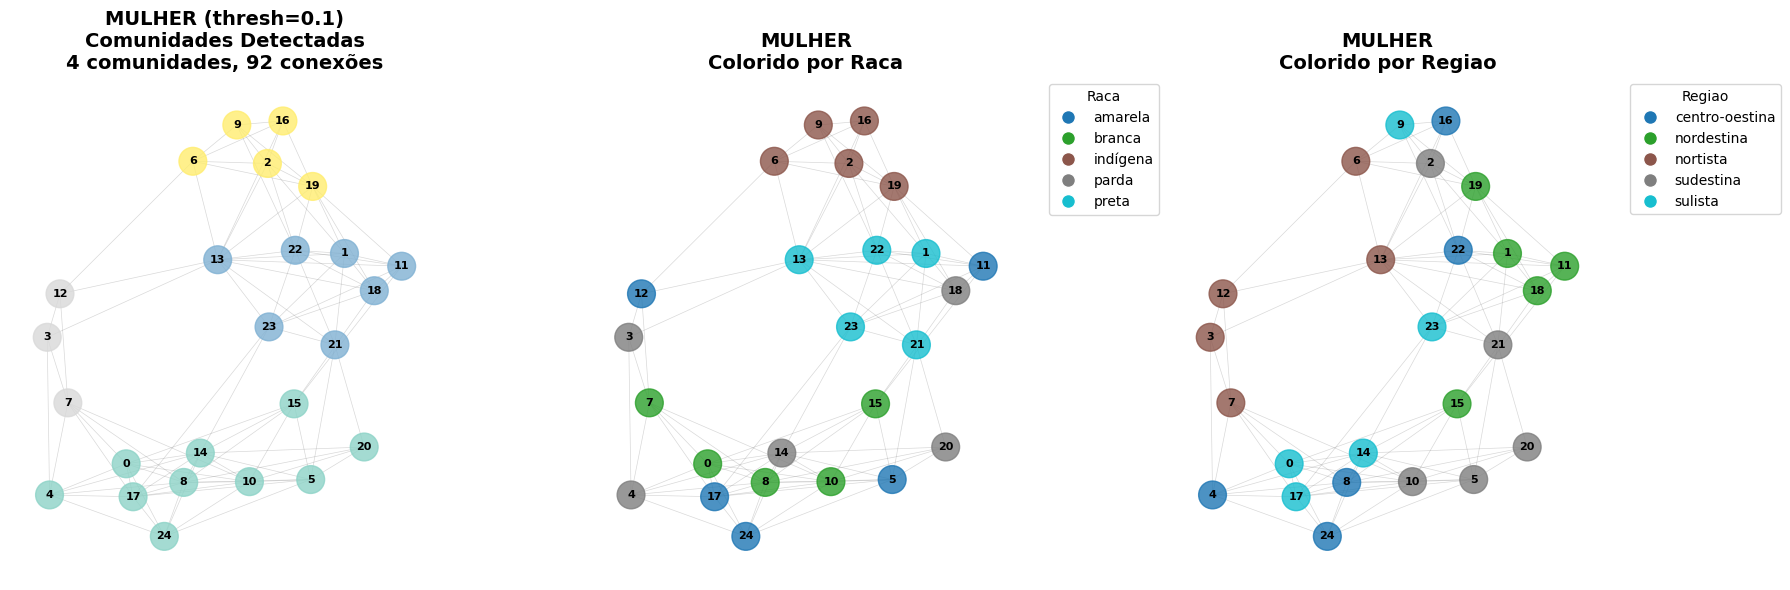


--- Threshold: 0.3 ---
Graph: 25 nodes, 55 edges
Using louvain communities: 4 communities
Visualizing mulher graph with communities, raca, regiao


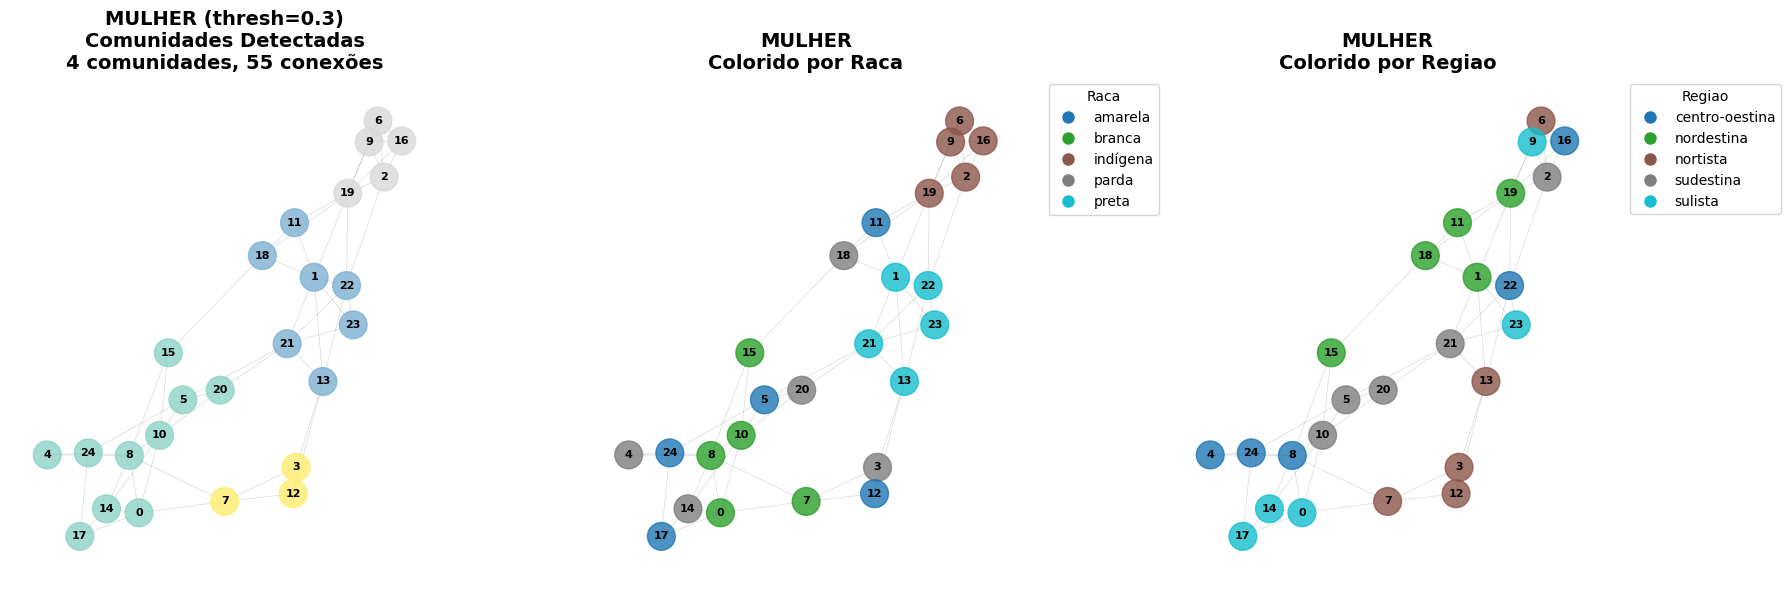


--- Threshold: 0.5 ---
Graph: 25 nodes, 29 edges
Using louvain communities: 8 communities
Visualizing mulher graph with communities, raca, regiao


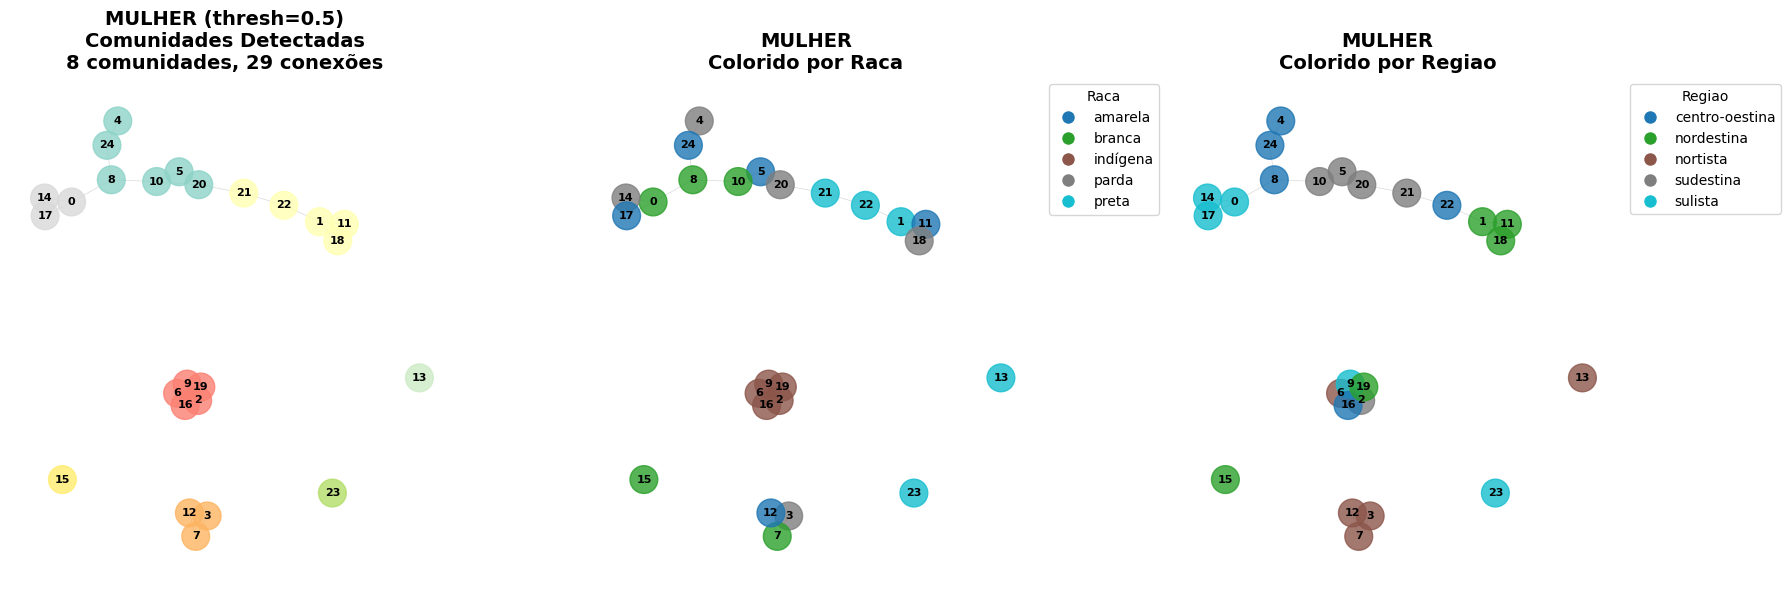


--- Threshold: 0.7 ---
Graph: 25 nodes, 12 edges
Using louvain communities: 18 communities
Visualizing mulher graph with communities, raca, regiao


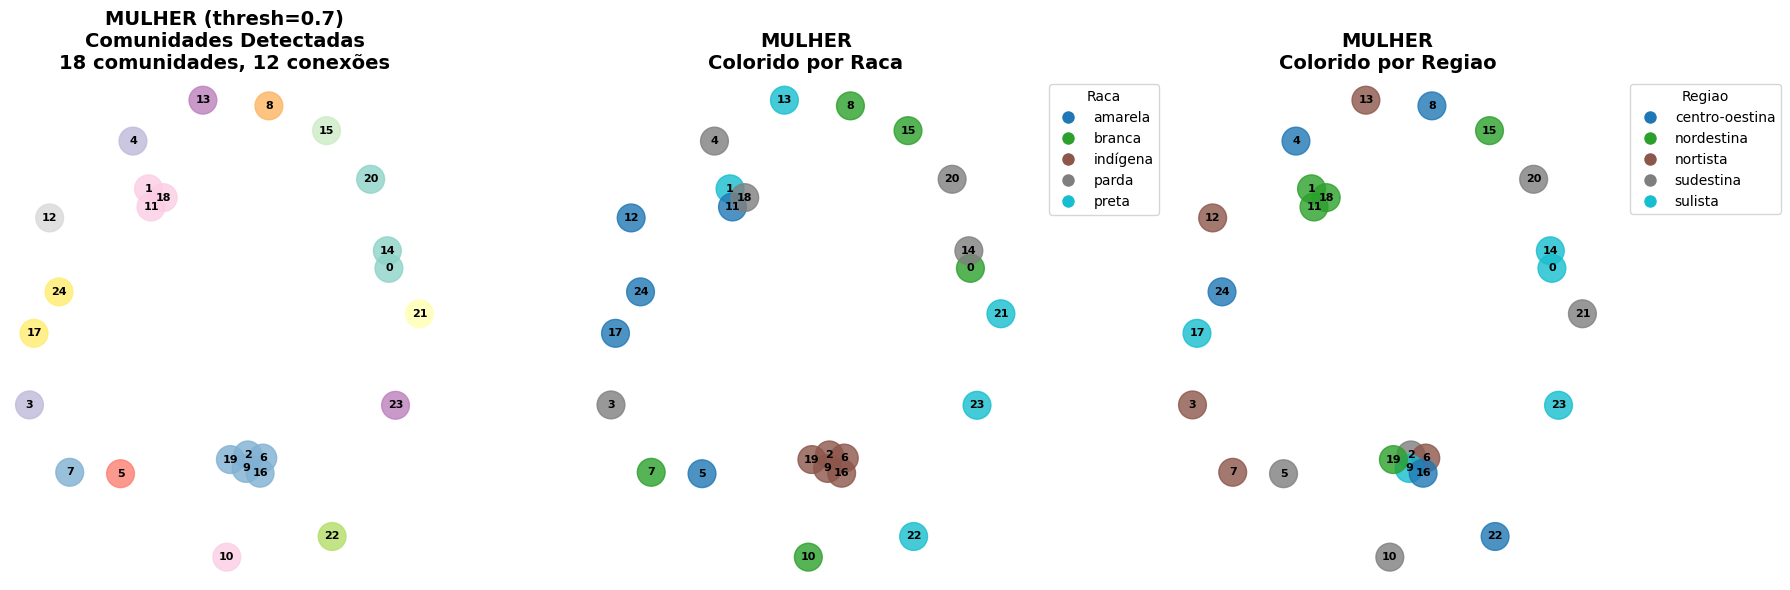


VISUALIZING HOMEM - ALL THRESHOLDS
Found 4 valid thresholds: [0.1, 0.3, 0.5, 0.7]

--- Threshold: 0.1 ---
Graph: 25 nodes, 83 edges
Using louvain communities: 4 communities
Visualizing homem graph with communities, raca, regiao


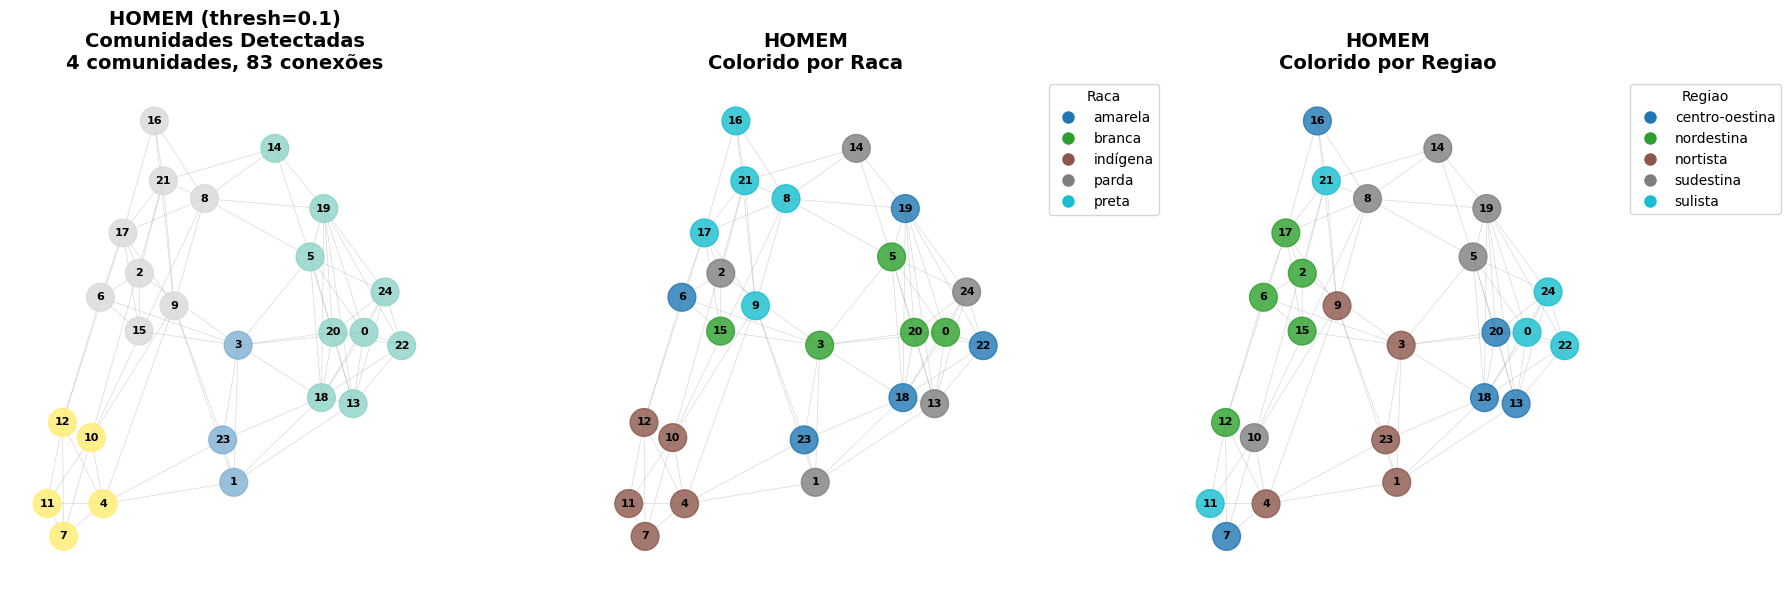


--- Threshold: 0.3 ---
Graph: 25 nodes, 47 edges
Using louvain communities: 5 communities
Visualizing homem graph with communities, raca, regiao


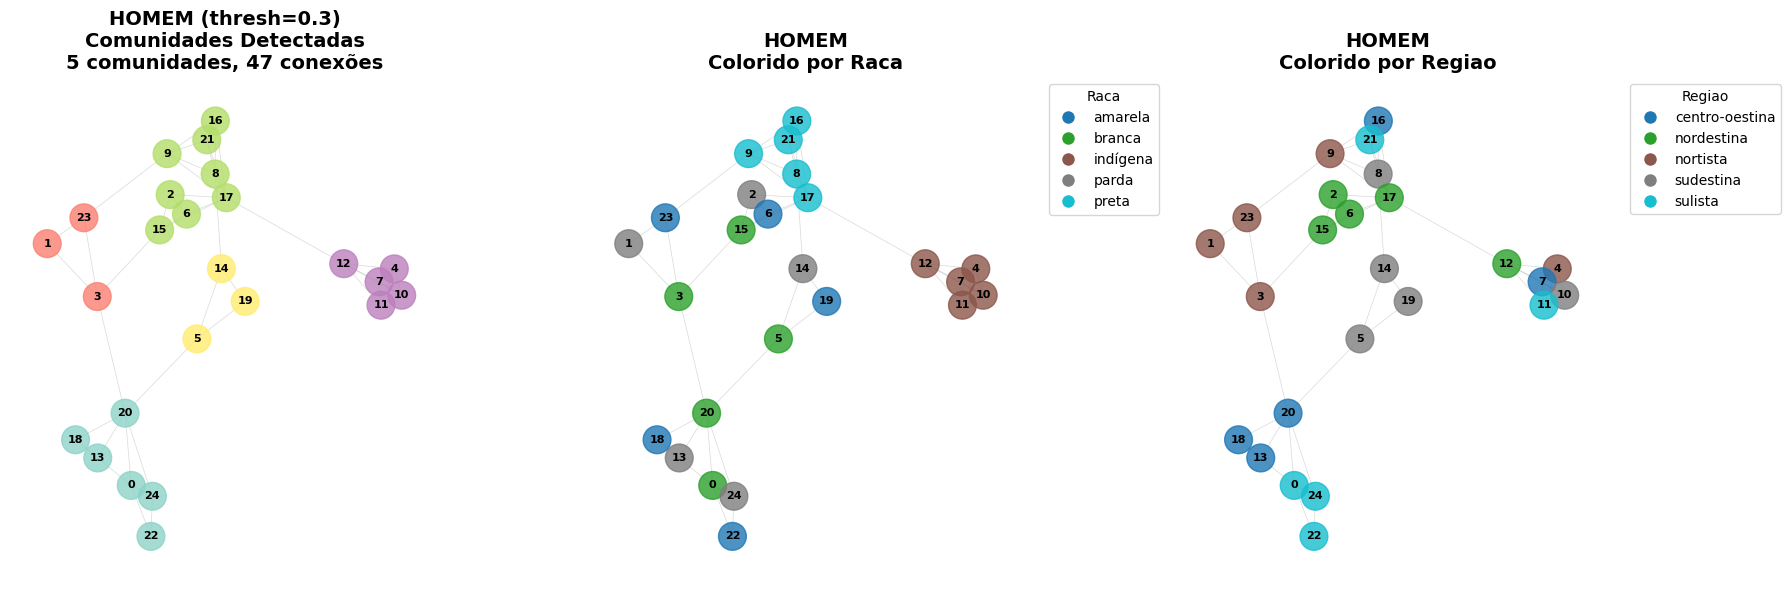


--- Threshold: 0.5 ---
Graph: 25 nodes, 31 edges
Using louvain communities: 7 communities
Visualizing homem graph with communities, raca, regiao


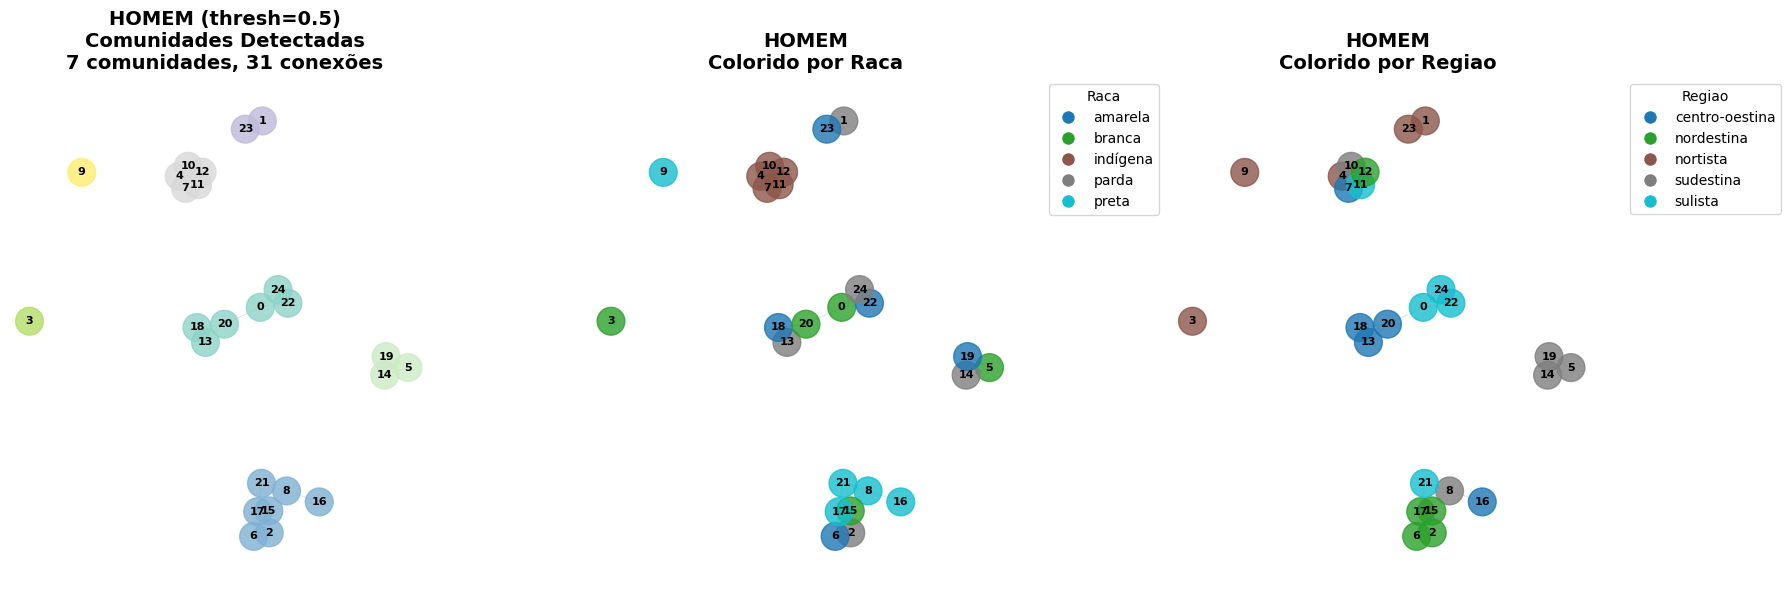


--- Threshold: 0.7 ---
Graph: 25 nodes, 15 edges
Using louvain communities: 15 communities
Visualizing homem graph with communities, raca, regiao


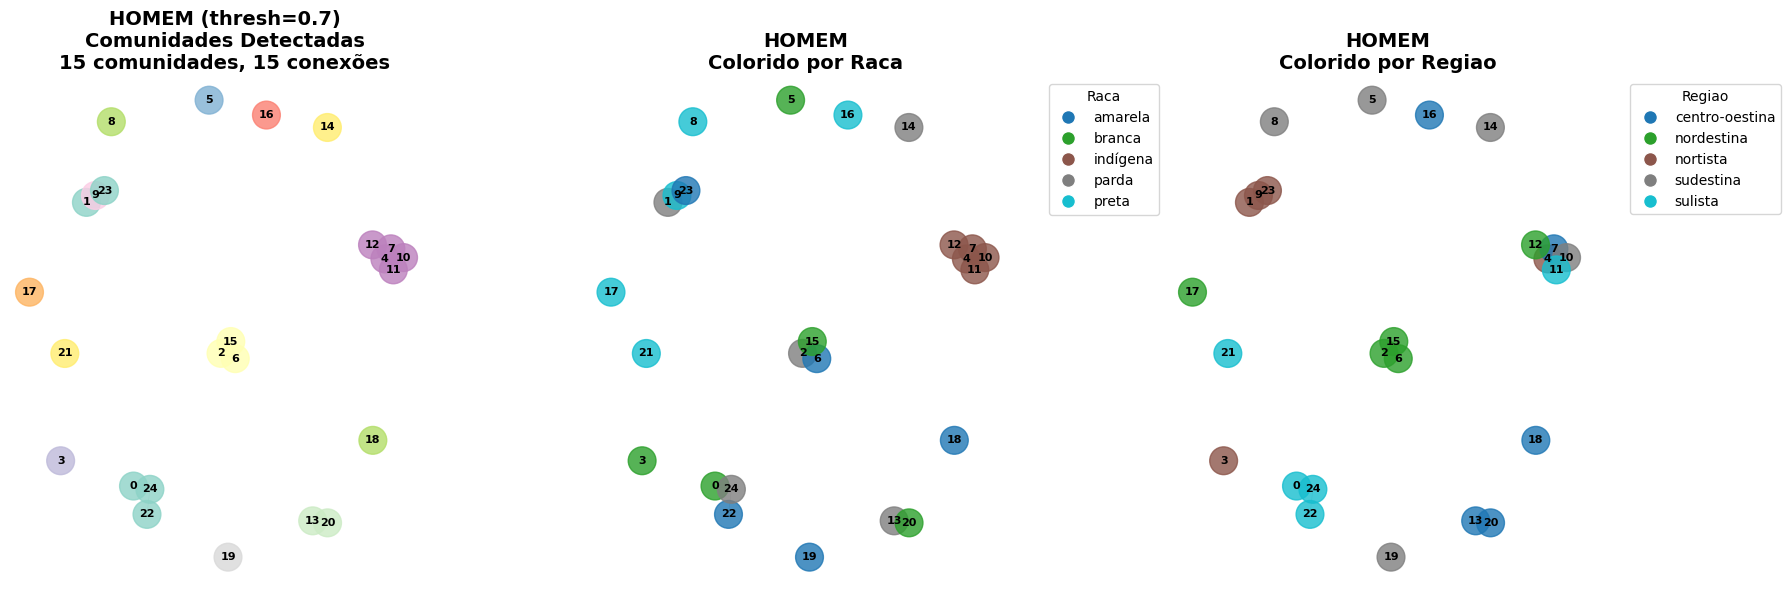


VISUALIZING NÃO-BINÁRIA - ALL THRESHOLDS
Found 4 valid thresholds: [0.1, 0.3, 0.5, 0.7]

--- Threshold: 0.1 ---
Graph: 25 nodes, 83 edges
Using louvain communities: 4 communities
Visualizing não-binária graph with communities, raca, regiao


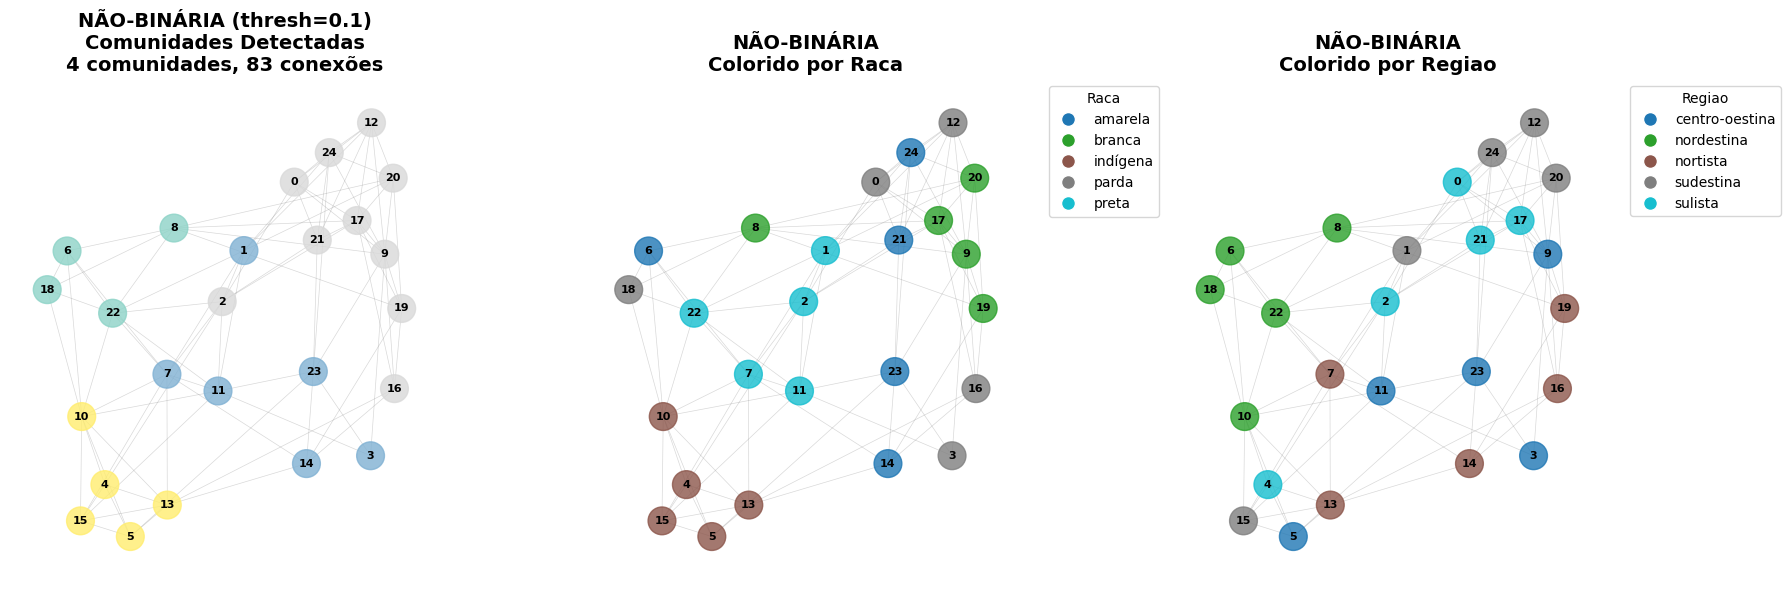


--- Threshold: 0.3 ---
Graph: 25 nodes, 42 edges
Using louvain communities: 4 communities
Visualizing não-binária graph with communities, raca, regiao


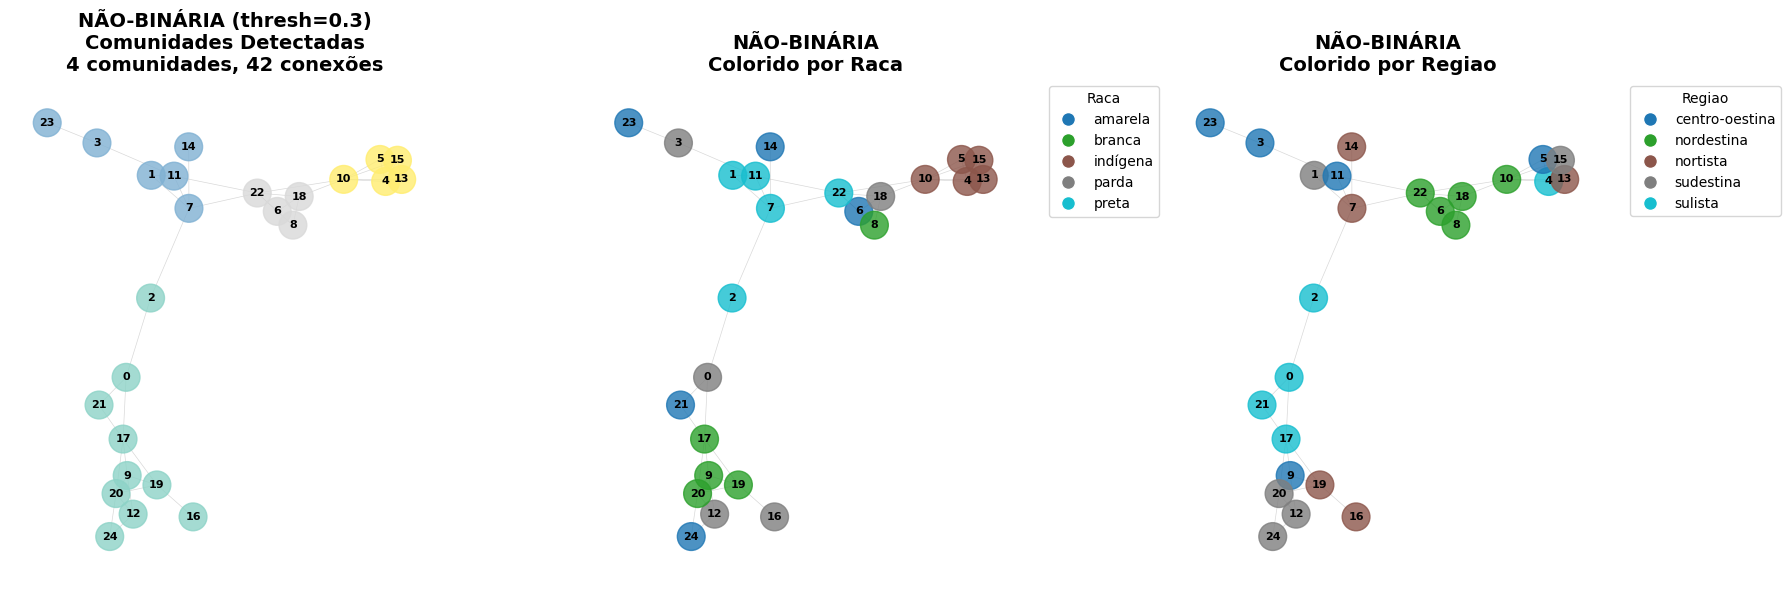


--- Threshold: 0.5 ---
Graph: 25 nodes, 19 edges
Using louvain communities: 11 communities
Visualizing não-binária graph with communities, raca, regiao


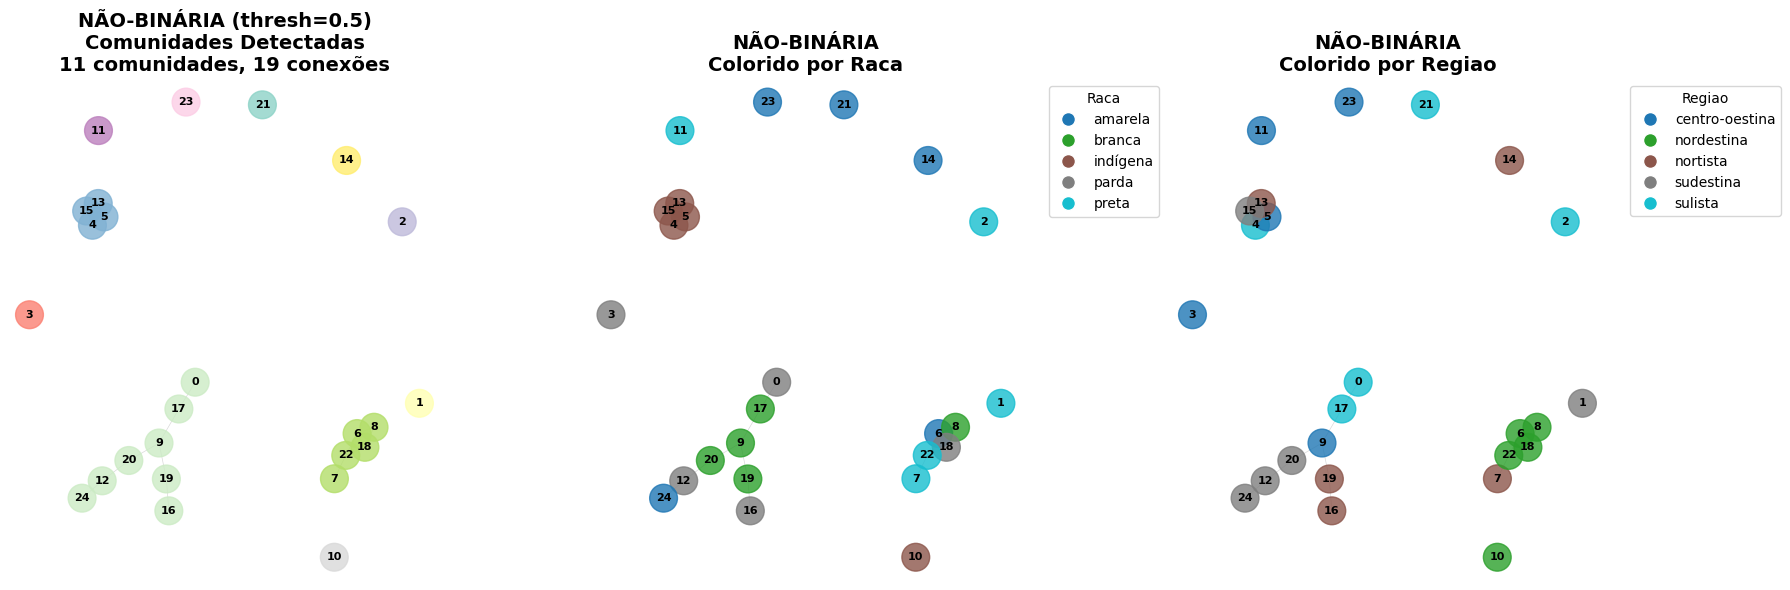


--- Threshold: 0.7 ---
Graph: 25 nodes, 2 edges
Using louvain communities: 23 communities
Visualizing não-binária graph with communities, raca, regiao


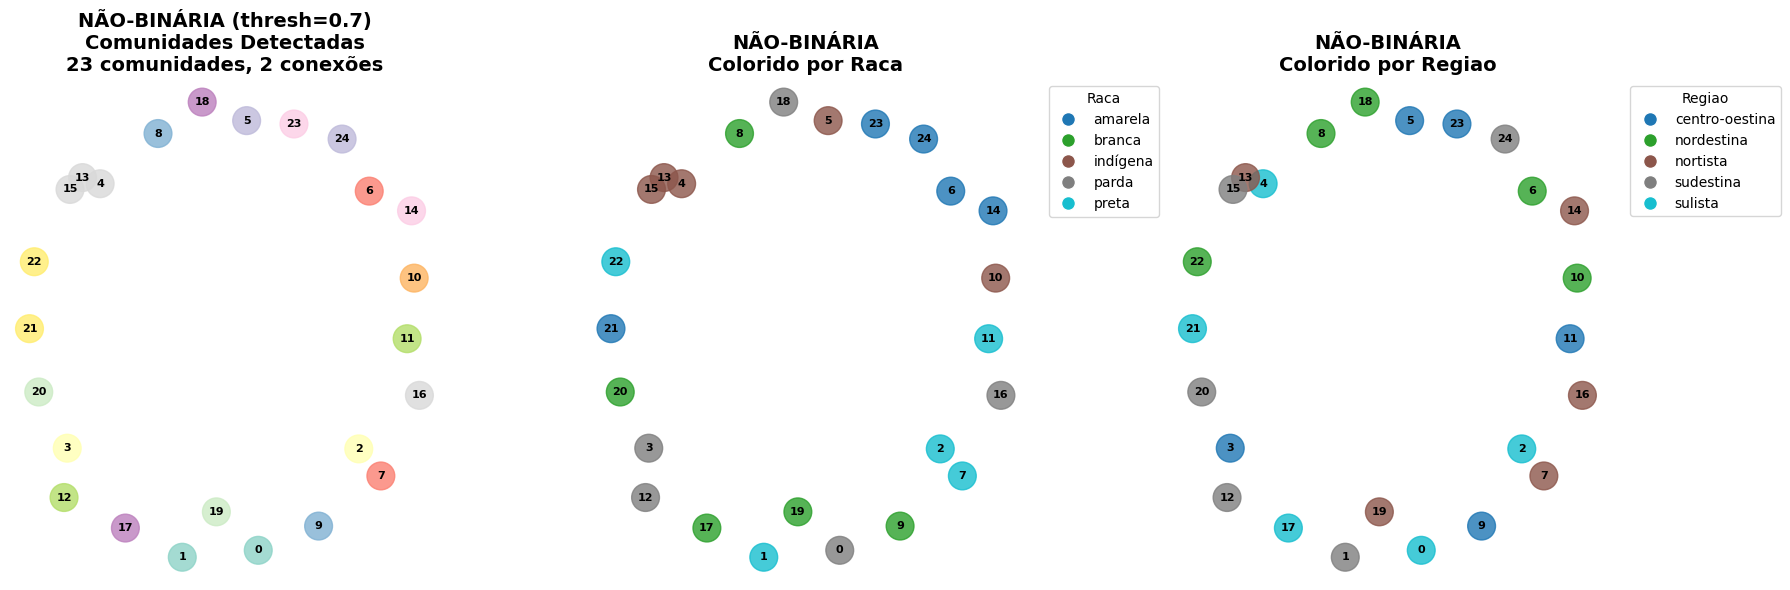

In [87]:

# Now iterate through all generos and all thresholds
for genero in genero_means.keys():
    if genero not in genero_results or 'thresholds' not in genero_results[genero]:
        print(f"\nSkipping {genero} - no threshold results available")
        continue
    
    print(f"\n{'='*60}")
    print(f"VISUALIZING {genero.upper()} - ALL THRESHOLDS")
    print(f"{'='*60}")
    
    genero_df = filtered_mean_embeddings_df[filtered_mean_embeddings_df['genero'] == genero].copy()
    genero_mean = genero_means[genero]
    
    # Get all valid thresholds (ones with edges)
    valid_thresholds = []
    for threshold, result in genero_results[genero]['thresholds'].items():
        if isinstance(result, dict) and result.get('edges', 0) > 0:
            valid_thresholds.append((threshold, result))
    
    if not valid_thresholds:
        print(f"No suitable thresholds found for {genero} - no edges in any graph")
        continue
    
    # Sort thresholds for consistent display
    valid_thresholds.sort(key=lambda x: x[0])
    
    print(f"Found {len(valid_thresholds)} valid thresholds: {[t[0] for t in valid_thresholds]}")
    
    # Visualize each threshold
    for threshold, result in valid_thresholds:
        print(f"\n--- Threshold: {threshold} ---")
        
        # Recreate the graph for visualization
        G = create_genero_similarity_graph(genero_df, genero_mean, threshold=threshold)
        
        print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        
        # Get communities for visualization
        communities = {}
        if 'communities' in result and 'louvain' in result['communities']:
            communities = result['communities']['louvain']
            community_method = "louvain"
        elif 'communities' in result and 'greedy' in result['communities']:
            greedy_communities = result['communities']['greedy']
            communities = {node: i for i, community in enumerate(greedy_communities) 
                          for node in community}
            community_method = "greedy"
        
        if communities:
            print(f"Using {community_method} communities: {len(set(communities.values()))} communities")
        else:
            print("No communities found for visualization")
        
        # Visualize with multiple configurations in same image
        config_cols_to_visualize = ['raca', 'regiao']  # Show raca and regiao as requested
        available_configs = [col for col in config_cols_to_visualize if col in genero_df.columns]
        
        if available_configs:
            print(f"Visualizing {genero} graph with communities, {', '.join(available_configs)}")
            visualize_genero_graph_multiple_configs(
                G, communities, genero_df, genero, threshold, available_configs
            )
        else:
            print(f"No valid configuration columns found for {genero}")

### UMAP + HDBSCAN

In [92]:
# Debug: Check DataFrame structure before clustering
print("Debugging DataFrame structure:")
print(f"filtered_mean_embeddings_df shape: {filtered_mean_embeddings_df.shape}")
print(f"Columns: {list(filtered_mean_embeddings_df.columns)}")
print(f"Column types:")
for col in filtered_mean_embeddings_df.columns:
    print(f"  {col}: {filtered_mean_embeddings_df[col].dtype}")

print(f"\nconfig_cols: {config_cols}")

# Check what columns contain embeddings
numeric_cols = filtered_mean_embeddings_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns: {numeric_cols}")

# Check a sample
print(f"\nSample of data:")
print(filtered_mean_embeddings_df.head())

Debugging DataFrame structure:
filtered_mean_embeddings_df shape: (75, 7)
Columns: ['messageId', 'mean_embedding', 'genero', 'raca', 'regiao', 'safe_prompt_name', 'model']
Column types:
  messageId: object
  mean_embedding: object
  genero: object
  raca: object
  regiao: object
  safe_prompt_name: object
  model: object

config_cols: ['genero', 'raca', 'regiao', 'safe_prompt_name']
Numeric columns: []

Sample of data:
                              messageId  \
0  01861752-b94f-5b29-83f0-47ad21177678   
1  02a89d41-4e4b-5317-bcbf-1b18e36455b1   
2  0547c418-2625-5383-acbc-7347146aa6a6   
3  0af530cd-dc3f-5e9e-a2c2-c0b86a12d601   
4  0c05baf5-3572-5e40-abeb-8a24f45f20e5   

                                      mean_embedding  genero      raca  \
0  [tensor(0.9274), tensor(0.1564), tensor(0.0496...  mulher    branca   
1  [tensor(0.4831), tensor(-0.0076), tensor(0.047...  mulher     preta   
2  [tensor(0.7162), tensor(0.3280), tensor(0.4963...   homem    branca   
3  [tensor(0.0331), te


UMAP + HDBSCAN CLUSTERING ANALYSIS
UMAP and HDBSCAN already available
Performing clustering analysis for each genero...

CLUSTERING ANALYSIS FOR MULHER
Starting UMAP + HDBSCAN analysis...
Input data: 25 samples
Successfully extracted embeddings with shape: (25, 1024)
Using 1024 embedding dimensions
Performing UMAP reduction to 10 dimensions...
UMAP completed. Shape: (25, 10)
Performing HDBSCAN clustering...
Clustering completed:
  - Number of clusters: 2
  - Number of noise points: 0
  - Percentage of data clustered: 100.0%
  - Silhouette score: 0.769

Creating visualizations for mulher...


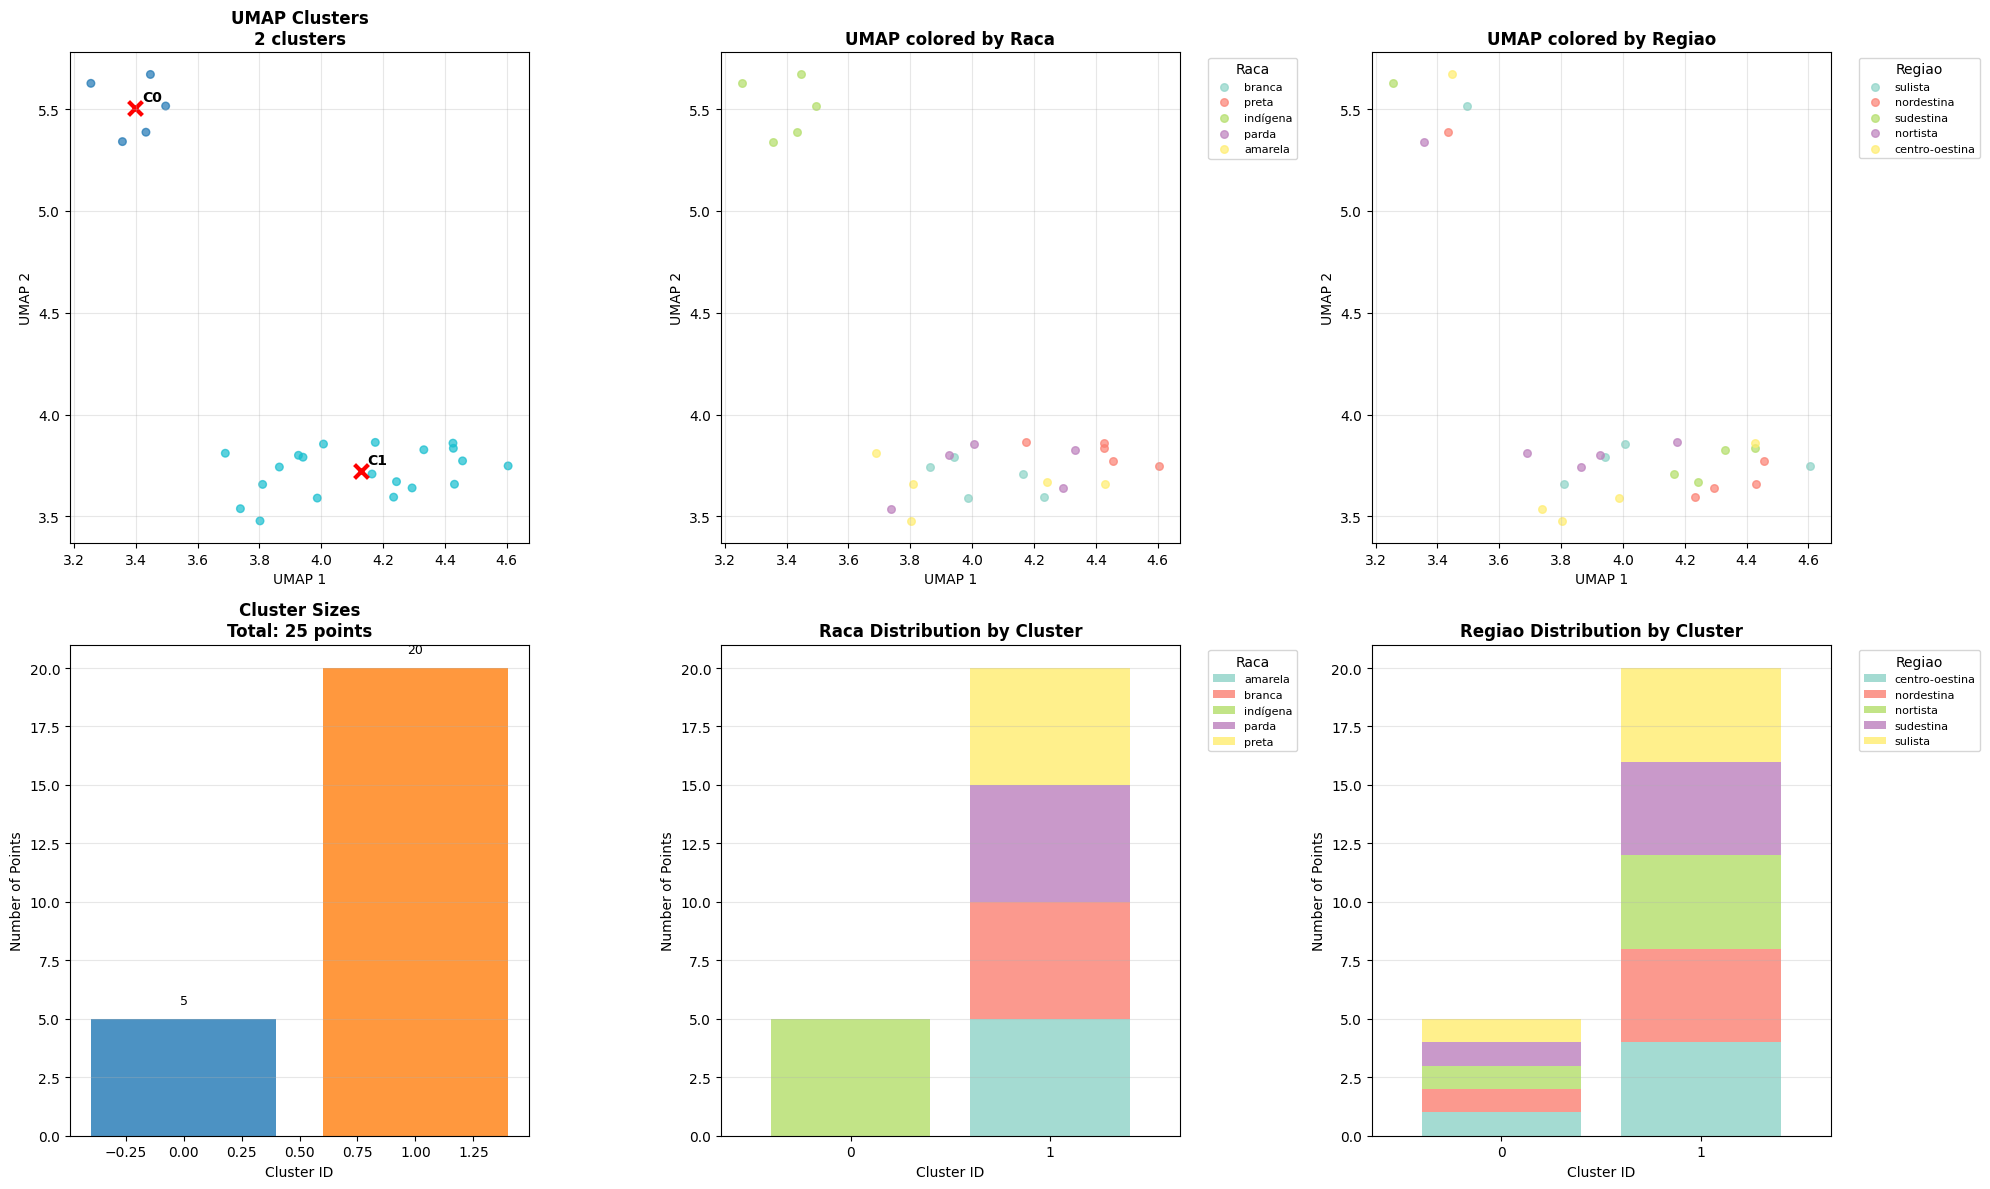


DETAILED CLUSTER ANALYSIS

--- CLUSTER 0 ---
Size: 5 points (20.0% of total)

RACA:
  indígena: 5 (100.0%)
  → Dominant raca: indígena (100.0%)

REGIAO:
  sudestina: 1 (20.0%)
  nortista: 1 (20.0%)
  sulista: 1 (20.0%)
  centro-oestina: 1 (20.0%)
  nordestina: 1 (20.0%)
  → Dominant regiao: sudestina (20.0%)

--- CLUSTER 1 ---
Size: 20 points (80.0% of total)

RACA:
  branca: 5 (25.0%)
  preta: 5 (25.0%)
  parda: 5 (25.0%)
  amarela: 5 (25.0%)
  → Dominant raca: branca (25.0%)

REGIAO:
  sulista: 4 (20.0%)
  nordestina: 4 (20.0%)
  nortista: 4 (20.0%)
  centro-oestina: 4 (20.0%)
  sudestina: 4 (20.0%)
  → Dominant regiao: sulista (20.0%)

CLUSTERING ANALYSIS FOR HOMEM
Starting UMAP + HDBSCAN analysis...
Input data: 25 samples
Successfully extracted embeddings with shape: (25, 1024)
Using 1024 embedding dimensions
Performing UMAP reduction to 10 dimensions...
UMAP completed. Shape: (25, 10)
Performing HDBSCAN clustering...
Clustering completed:
  - Number of clusters: 2
  - Number of n

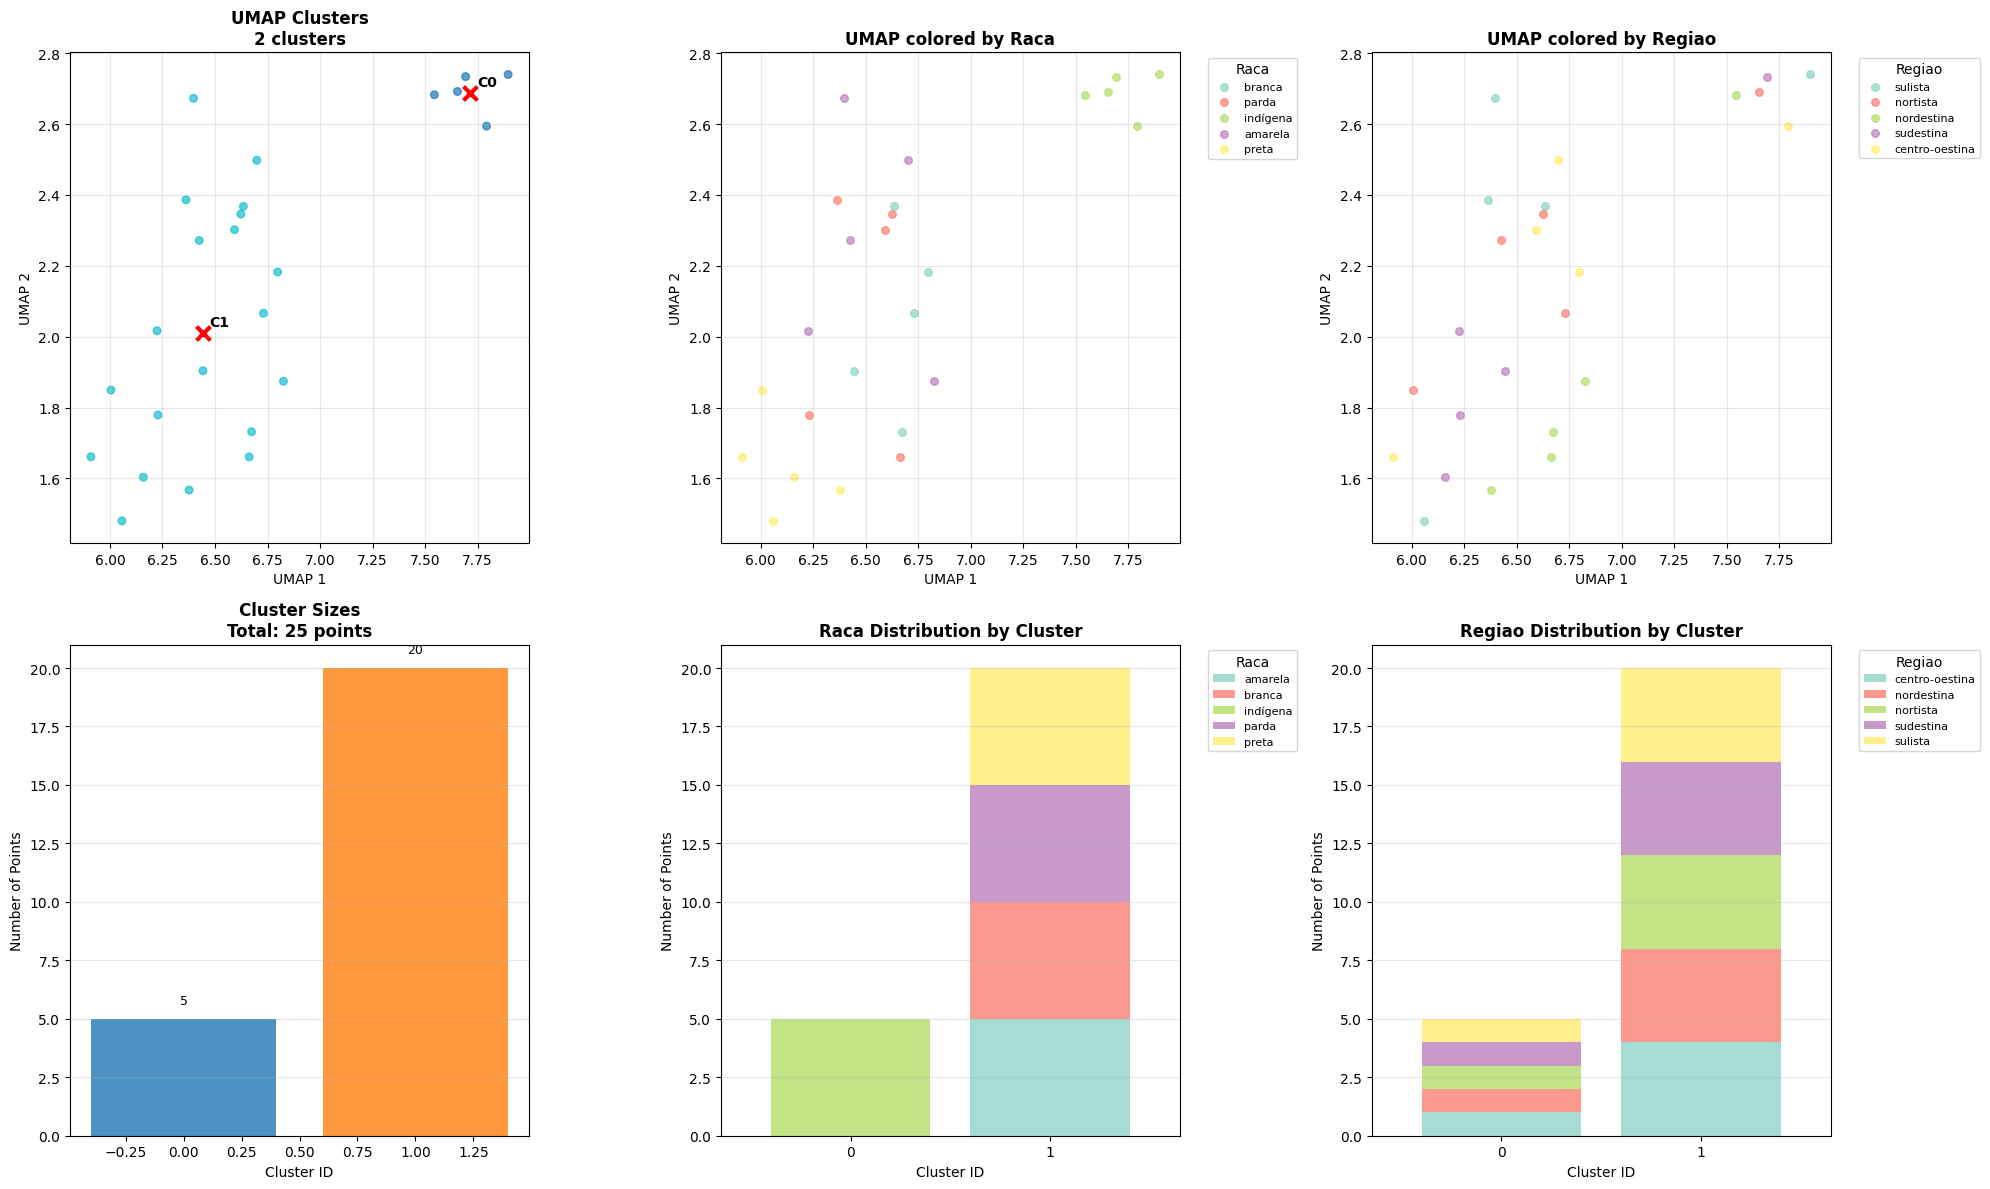


DETAILED CLUSTER ANALYSIS

--- CLUSTER 0 ---
Size: 5 points (20.0% of total)

RACA:
  indígena: 5 (100.0%)
  → Dominant raca: indígena (100.0%)

REGIAO:
  nortista: 1 (20.0%)
  centro-oestina: 1 (20.0%)
  sudestina: 1 (20.0%)
  sulista: 1 (20.0%)
  nordestina: 1 (20.0%)
  → Dominant regiao: nortista (20.0%)

--- CLUSTER 1 ---
Size: 20 points (80.0% of total)

RACA:
  branca: 5 (25.0%)
  parda: 5 (25.0%)
  amarela: 5 (25.0%)
  preta: 5 (25.0%)
  → Dominant raca: branca (25.0%)

REGIAO:
  sulista: 4 (20.0%)
  nortista: 4 (20.0%)
  nordestina: 4 (20.0%)
  sudestina: 4 (20.0%)
  centro-oestina: 4 (20.0%)
  → Dominant regiao: sulista (20.0%)

CLUSTERING ANALYSIS FOR NÃO-BINÁRIA
Starting UMAP + HDBSCAN analysis...
Input data: 25 samples
Successfully extracted embeddings with shape: (25, 1024)
Using 1024 embedding dimensions
Performing UMAP reduction to 10 dimensions...
UMAP completed. Shape: (25, 10)
Performing HDBSCAN clustering...
Clustering completed:
  - Number of clusters: 2
  - Number

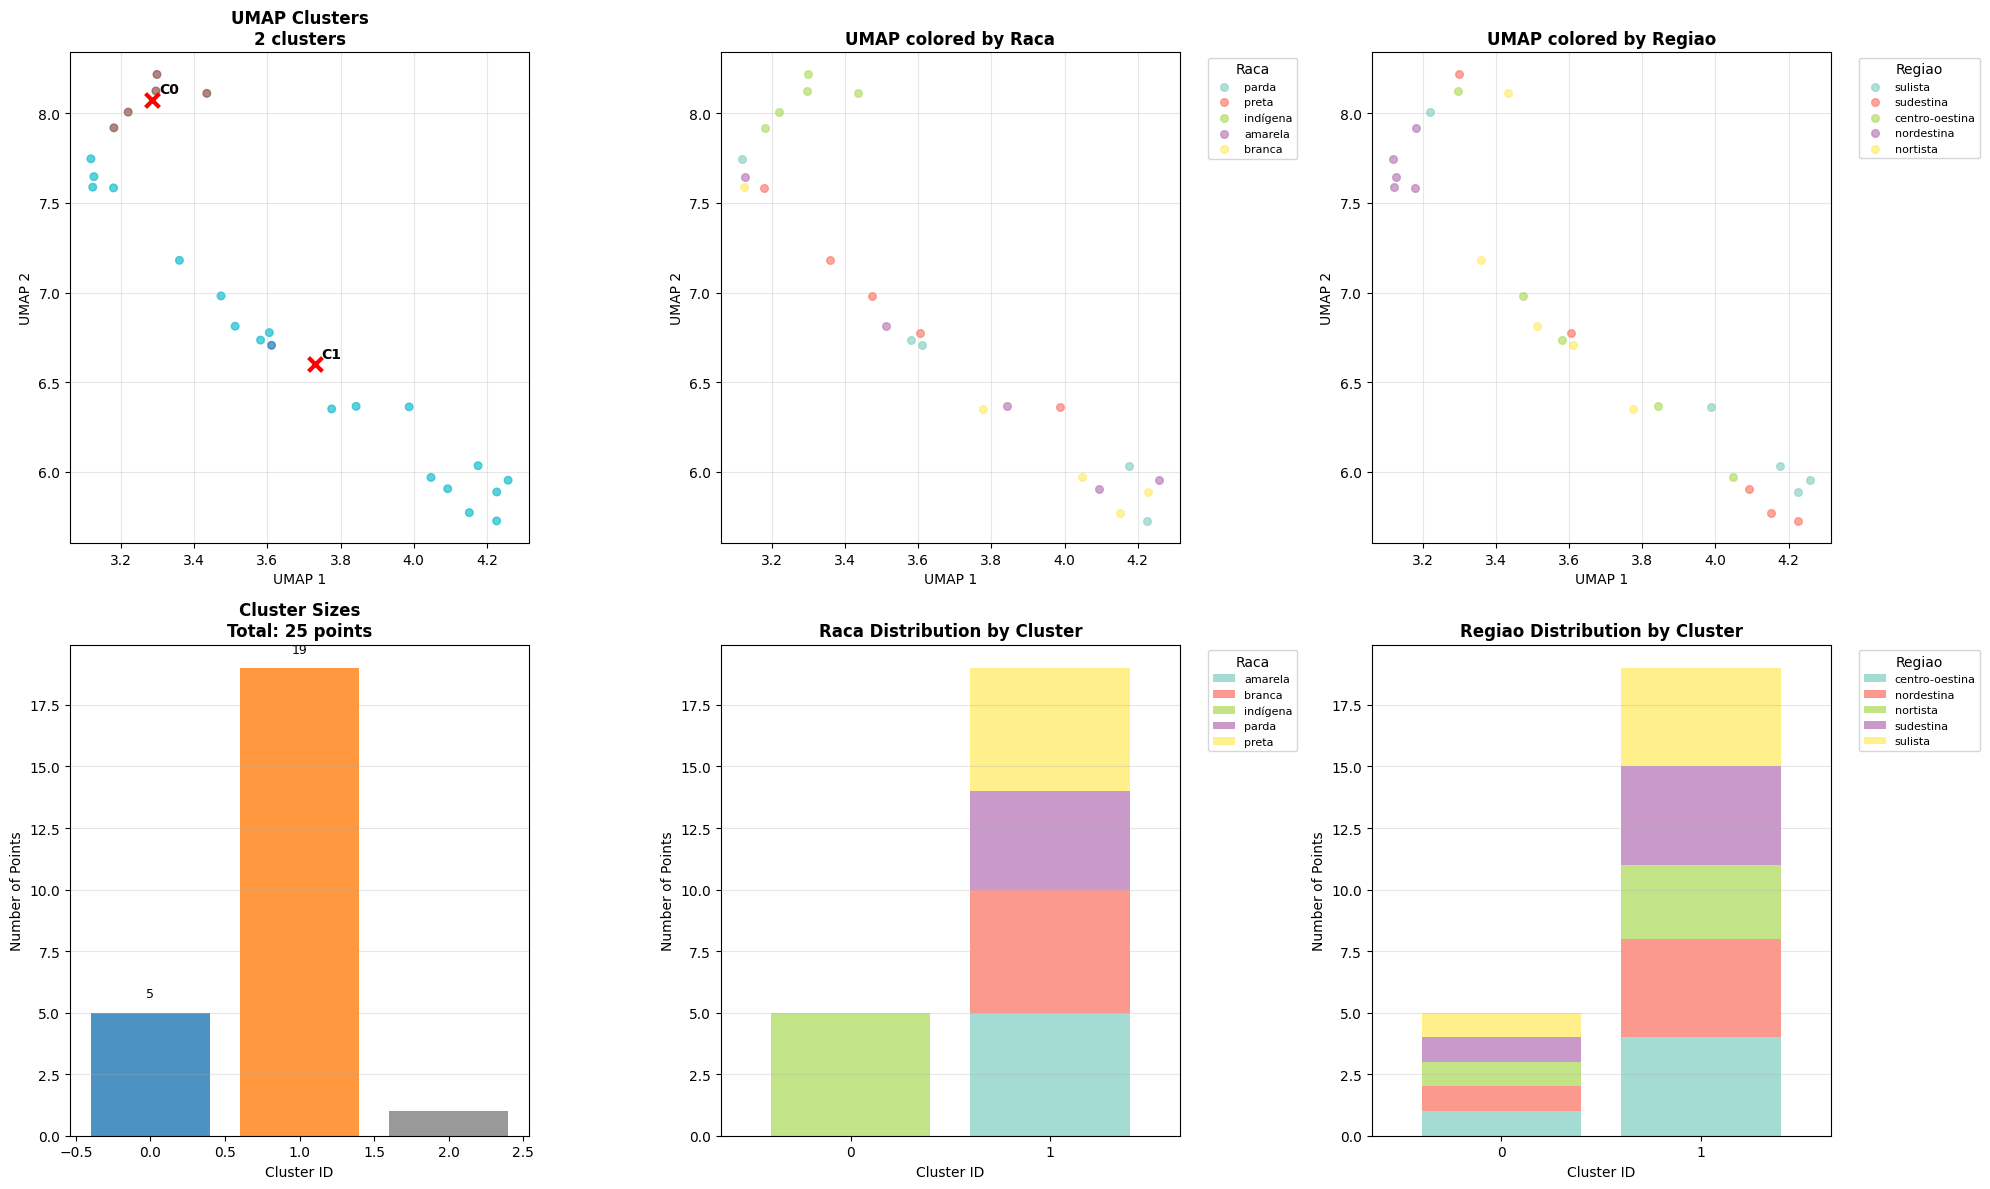


DETAILED CLUSTER ANALYSIS

--- CLUSTER 0 ---
Size: 5 points (20.0% of total)

RACA:
  indígena: 5 (100.0%)
  → Dominant raca: indígena (100.0%)

REGIAO:
  sulista: 1 (20.0%)
  centro-oestina: 1 (20.0%)
  nordestina: 1 (20.0%)
  nortista: 1 (20.0%)
  sudestina: 1 (20.0%)
  → Dominant regiao: sulista (20.0%)

--- CLUSTER 1 ---
Size: 19 points (76.0% of total)

RACA:
  preta: 5 (26.3%)
  amarela: 5 (26.3%)
  branca: 5 (26.3%)
  parda: 4 (21.1%)
  → Dominant raca: preta (26.3%)

REGIAO:
  sulista: 4 (21.1%)
  sudestina: 4 (21.1%)
  centro-oestina: 4 (21.1%)
  nordestina: 4 (21.1%)
  nortista: 3 (15.8%)
  → Dominant regiao: sulista (21.1%)

--- NOISE POINTS ---
Size: 1 points (4.0% of total)

RACA in noise:
  parda: 1 (100.0%)

REGIAO in noise:
  nortista: 1 (100.0%)

CLUSTERING ANALYSIS COMPLETED


In [99]:
# UMAP + HDBSCAN Clustering Analysis
print("\n" + "="*80)
print("UMAP + HDBSCAN CLUSTERING ANALYSIS")
print("="*80)

# Install required packages if not available
try:
    import umap
    import hdbscan
    print("UMAP and HDBSCAN already available")
except ImportError:
    print("Installing UMAP and HDBSCAN...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn", "hdbscan"])
    import umap
    import hdbscan
    print("UMAP and HDBSCAN installed successfully")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import torch

def extract_embeddings_from_tensors(embeddings_df, embedding_col='mean_embedding'):
    """
    Extract embeddings from tensor format and convert to numpy array
    
    Args:
        embeddings_df: DataFrame with tensor-based embeddings
        embedding_col: Column name containing the embeddings
    
    Returns:
        numpy.ndarray: Embeddings matrix
    """
    embeddings_list = []
    
    for idx, row in embeddings_df.iterrows():
        embedding = row[embedding_col]
        
        # Handle different formats
        if isinstance(embedding, list):
            # Convert list of tensors to numpy
            if all(torch.is_tensor(x) for x in embedding):
                # List of tensor scalars
                embedding_array = np.array([x.item() if x.dim() == 0 else x.numpy() for x in embedding])
            else:
                # Regular list of numbers
                embedding_array = np.array(embedding)
        elif torch.is_tensor(embedding):
            # Single tensor
            embedding_array = embedding.numpy() if embedding.dim() > 0 else np.array([embedding.item()])
        elif isinstance(embedding, np.ndarray):
            embedding_array = embedding
        else:
            # Try to convert directly
            embedding_array = np.array(embedding)
        
        # Flatten if needed
        if embedding_array.ndim > 1:
            embedding_array = embedding_array.flatten()
            
        embeddings_list.append(embedding_array)
    
    # Stack all embeddings
    embeddings_matrix = np.stack(embeddings_list)
    return embeddings_matrix

def perform_umap_hdbscan_analysis(embeddings_df, config_cols, embedding_col='mean_embedding', n_components=2, n_neighbors=15, min_dist=0.1, min_cluster_size=5, min_samples=3):
    """
    Perform UMAP dimensionality reduction followed by HDBSCAN clustering
    
    Args:
        embeddings_df: DataFrame with embeddings and metadata
        config_cols: Configuration columns to analyze
        embedding_col: Column containing the embeddings
        n_components: Number of UMAP dimensions (2 for visualization, higher for clustering)
        n_neighbors: UMAP n_neighbors parameter
        min_dist: UMAP min_dist parameter
        min_cluster_size: HDBSCAN min_cluster_size parameter
        min_samples: HDBSCAN min_samples parameter
    
    Returns:
        dict: Analysis results including embeddings, clusters, and metrics
    """
    print(f"Starting UMAP + HDBSCAN analysis...")
    print(f"Input data: {len(embeddings_df)} samples")
    
    # Extract embeddings matrix
    try:
        X = extract_embeddings_from_tensors(embeddings_df, embedding_col)
        print(f"Successfully extracted embeddings with shape: {X.shape}")
    except Exception as e:
        print(f"Error extracting embeddings: {e}")
        return None
    
    if X.shape[1] == 0:
        print("Error: No embedding dimensions found")
        return None
    
    print(f"Using {X.shape[1]} embedding dimensions")
    
    # Standardize the embeddings
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # UMAP dimensionality reduction
    print(f"Performing UMAP reduction to {n_components} dimensions...")
    umap_reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42,
        metric='cosine'  # Good for text embeddings
    )
    
    X_umap = umap_reducer.fit_transform(X_scaled)
    print(f"UMAP completed. Shape: {X_umap.shape}")
    
    # HDBSCAN clustering
    print(f"Performing HDBSCAN clustering...")
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean'
    )
    
    cluster_labels = clusterer.fit_predict(X_umap)
    
    # Calculate metrics
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    print(f"Clustering completed:")
    print(f"  - Number of clusters: {n_clusters}")
    print(f"  - Number of noise points: {n_noise}")
    print(f"  - Percentage of data clustered: {((len(cluster_labels) - n_noise) / len(cluster_labels)) * 100:.1f}%")
    
    # Calculate silhouette score (only for clustered points)
    if n_clusters > 1:
        clustered_mask = cluster_labels != -1
        if np.sum(clustered_mask) > 1:
            silhouette_avg = silhouette_score(X_umap[clustered_mask], cluster_labels[clustered_mask])
            print(f"  - Silhouette score: {silhouette_avg:.3f}")
        else:
            silhouette_avg = None
    else:
        silhouette_avg = None
    
    # Create results DataFrame
    results_df = embeddings_df.copy()
    results_df['umap_x'] = X_umap[:, 0]
    results_df['umap_y'] = X_umap[:, 1]
    if n_components > 2:
        for i in range(2, n_components):
            results_df[f'umap_{i+1}'] = X_umap[:, i]
    results_df['cluster'] = cluster_labels
    results_df['is_noise'] = cluster_labels == -1
    
    return {
        'results_df': results_df,
        'umap_embeddings': X_umap,
        'cluster_labels': cluster_labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette_score': silhouette_avg,
        'umap_reducer': umap_reducer,
        'clusterer': clusterer,
        'original_embeddings': X
    }

def visualize_umap_clusters(analysis_results, config_cols, figsize=(20, 12)):
    """
    Create comprehensive visualizations of UMAP + HDBSCAN results
    """
    results_df = analysis_results['results_df']
    n_clusters = analysis_results['n_clusters']
    
    # Create subplot layout
    n_configs = len(config_cols) + 1  # +1 for clusters
    fig, axes = plt.subplots(2, n_configs, figsize=figsize)
    if n_configs == 1:
        axes = axes.reshape(2, 1)
    
    # Color palette for clusters
    cluster_colors = plt.cm.tab10(np.linspace(0, 1, max(10, n_clusters + 1)))
    
    # Top row: UMAP scatter plots
    for i, col in enumerate(['cluster'] + config_cols):
        ax = axes[0, i]
        
        if col == 'cluster':
            # Cluster visualization
            scatter = ax.scatter(results_df['umap_x'], results_df['umap_y'], 
                               c=results_df['cluster'], cmap='tab10', 
                               alpha=0.7, s=30)
            ax.set_title(f'UMAP Clusters\n{n_clusters} clusters', fontsize=12, fontweight='bold')
            
            # Add cluster centers
            for cluster_id in range(n_clusters):
                cluster_mask = results_df['cluster'] == cluster_id
                if np.sum(cluster_mask) > 0:
                    center_x = results_df.loc[cluster_mask, 'umap_x'].mean()
                    center_y = results_df.loc[cluster_mask, 'umap_y'].mean()
                    ax.scatter(center_x, center_y, c='red', marker='x', s=100, linewidths=3)
                    ax.annotate(f'C{cluster_id}', (center_x, center_y), xytext=(5, 5), 
                              textcoords='offset points', fontsize=10, fontweight='bold')
        
        else:
            # Configuration attribute visualization
            if col in results_df.columns:
                unique_values = results_df[col].unique()
                colors = plt.cm.Set3(np.linspace(0, 1, len(unique_values)))
                
                for j, value in enumerate(unique_values):
                    mask = results_df[col] == value
                    ax.scatter(results_df.loc[mask, 'umap_x'], results_df.loc[mask, 'umap_y'],
                             c=[colors[j]], label=value, alpha=0.7, s=30)
                
                ax.legend(title=col.title(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
                ax.set_title(f'UMAP colored by {col.title()}', fontsize=12, fontweight='bold')
        
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        ax.grid(True, alpha=0.3)
    
    # Bottom row: Cluster composition bar plots
    for i, col in enumerate(['cluster_sizes'] + config_cols):
        ax = axes[1, i]
        
        if col == 'cluster_sizes':
            # Cluster size distribution
            cluster_sizes = results_df[results_df['cluster'] != -1]['cluster'].value_counts().sort_index()
            noise_size = np.sum(results_df['cluster'] == -1)
            
            bars = ax.bar(range(len(cluster_sizes)), cluster_sizes.values, 
                         color=cluster_colors[:len(cluster_sizes)], alpha=0.8)
            
            if noise_size > 0:
                ax.bar(len(cluster_sizes), noise_size, color='gray', alpha=0.8, label='Noise')
            
            ax.set_xlabel('Cluster ID')
            ax.set_ylabel('Number of Points')
            ax.set_title(f'Cluster Sizes\nTotal: {len(results_df)} points', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='y')
            
            # Add value labels on bars
            for j, bar in enumerate(bars):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{int(height)}', ha='center', va='bottom', fontsize=9)
        
        else:
            # Configuration distribution within clusters
            if col in results_df.columns:
                clustered_df = results_df[results_df['cluster'] != -1]
                
                if len(clustered_df) > 0:
                    config_by_cluster = clustered_df.groupby(['cluster', col]).size().unstack(fill_value=0)
                    
                    config_by_cluster.plot(kind='bar', stacked=True, ax=ax, 
                                         alpha=0.8, width=0.8, colormap='Set3')
                    
                    ax.set_xlabel('Cluster ID')
                    ax.set_ylabel('Number of Points')
                    ax.set_title(f'{col.title()} Distribution by Cluster', fontsize=12, fontweight='bold')
                    ax.legend(title=col.title(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
                    ax.tick_params(axis='x', rotation=0)
                    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def analyze_cluster_characteristics(analysis_results, config_cols):
    """
    Analyze and print detailed characteristics of each cluster
    """
    results_df = analysis_results['results_df']
    n_clusters = analysis_results['n_clusters']
    
    print(f"\n{'='*60}")
    print("DETAILED CLUSTER ANALYSIS")
    print(f"{'='*60}")
    
    for cluster_id in range(n_clusters):
        cluster_mask = results_df['cluster'] == cluster_id
        cluster_data = results_df[cluster_mask]
        
        print(f"\n--- CLUSTER {cluster_id} ---")
        print(f"Size: {len(cluster_data)} points ({len(cluster_data)/len(results_df)*100:.1f}% of total)")
        
        # Analyze each configuration attribute
        for col in config_cols:
            if col in cluster_data.columns:
                value_counts = cluster_data[col].value_counts()
                total_in_cluster = len(cluster_data)
                
                print(f"\n{col.upper()}:")
                for value, count in value_counts.items():
                    percentage = (count / total_in_cluster) * 100
                    print(f"  {value}: {count} ({percentage:.1f}%)")
                
                # Find dominant attribute
                if len(value_counts) > 0:
                    dominant_value = value_counts.index[0]
                    dominant_pct = (value_counts.iloc[0] / total_in_cluster) * 100
                    print(f"  → Dominant {col}: {dominant_value} ({dominant_pct:.1f}%)")
    
    # Noise analysis
    noise_mask = results_df['cluster'] == -1
    if np.sum(noise_mask) > 0:
        noise_data = results_df[noise_mask]
        print(f"\n--- NOISE POINTS ---")
        print(f"Size: {len(noise_data)} points ({len(noise_data)/len(results_df)*100:.1f}% of total)")
        
        for col in config_cols:
            if col in noise_data.columns:
                value_counts = noise_data[col].value_counts()
                print(f"\n{col.upper()} in noise:")
                for value, count in value_counts.items():
                    percentage = (count / len(noise_data)) * 100
                    print(f"  {value}: {count} ({percentage:.1f}%)")

# Perform analysis for each genero separately
print("Performing clustering analysis for each genero...")

clustering_results = {}

for genero in genero_means.keys():
    print(f"\n{'='*70}")
    print(f"CLUSTERING ANALYSIS FOR {genero.upper()}")
    print(f"{'='*70}")
    
    # Filter data for this genero
    genero_df = filtered_mean_embeddings_df[filtered_mean_embeddings_df['genero'] == genero].copy()
    
    if len(genero_df) < 10:
        print(f"Skipping {genero} - insufficient data ({len(genero_df)} samples)")
        continue
    
    # Perform UMAP + HDBSCAN analysis
    analysis_results = perform_umap_hdbscan_analysis(
        genero_df, 
        config_cols,
        embedding_col='mean_embedding',
        n_components=10,
        n_neighbors=min(15, len(genero_df)//3),  # Adjust based on data size
        min_dist=0.1,
        min_cluster_size=max(5, len(genero_df)//20),  # Adjust based on data size
        min_samples=3
    )
    
    if analysis_results is None:
        print(f"Failed to perform analysis for {genero}")
        continue
        
    clustering_results[genero] = analysis_results
    
    # Visualize results
    print(f"\nCreating visualizations for {genero}...")
    visualize_umap_clusters(analysis_results, ['raca', 'regiao'])
    
    # Analyze cluster characteristics
    analyze_cluster_characteristics(analysis_results, ['raca', 'regiao'])

print("\n" + "="*80)
print("CLUSTERING ANALYSIS COMPLETED")
print("="*80)